# ПРОЕКТ 6 "Выбираем авто выгодно"

выполнили студенты:  
Плюснин Олег DSPR-27  
Розова Марина DSPR-29

### Загружаем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandas import Series

import pandas_profiling

import pprint as pp

# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction import FeatureHasher

import category_encoders as ce

from sklearn.model_selection import KFold
# from sklearn.base import clone

# from tqdm import tqdm

import warnings; warnings.simplefilter('ignore')

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

# import cufflinks as cf
# import plotly.offline
# cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.samplers import RandomSampler

from sklearn.linear_model import LinearRegression, Lasso, Ridge, PassiveAggressiveRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

from IPython.display import Image


### Функции

In [2]:
# функция расчета метрики mape
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [3]:
## Функция для нахождения выбросов в данных

def outliers(s):
    IQR = s.quantile(0.75) - s.quantile(0.25)
    perc25 = s.quantile(0.25)
    perc75 = s.quantile(0.75)
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{}, {}].".format(f, l))
    return perc25, perc75, f, l

Загружаем наши данные.

In [4]:
# загружаем датасет
train = pd.read_csv("../input/autoru2021/train.csv", low_memory=False)

In [5]:
train.head(5)

Unnamed: 0          body type       brand  \
0           0                NaN         NaN   
1           1              седан         KIA   
2           2    универсал 5 дв.  VOLKSWAGEN   
3           3              седан  VOLKSWAGEN   
4           4  внедорожник 5 дв.    CADILLAC   

                                                 URL  \
0                     https://auto.ru/cars/used/add/   
1  https://auto.ru/cars/used/sale/kia/rio/1104811...   
2  https://auto.ru/cars/used/sale/volkswagen/pass...   
3  https://auto.ru/cars/used/sale/volkswagen/polo...   
4  https://auto.ru/cars/used/sale/cadillac/escala...   

                                               color  \
0  автомобиля\r\nКоричневый\r\nБежевый\r\nБелый\r...   
1                                              белый   
2                                        серебристый   
3                                             чёрный   
4                                             чёрный   

                                               descr engine disp engine power  \
0                                                NaN         NaN          NaN   
1                                  Возможно в кредит     1.6 LTR      123 N12   
2  В хорошем состоянии,гаражное хранение,я второй...     2.0 LTR      140 N12   
3  Комплектация автомобиля:\r\n• USB\r\n• AUX\r\n...     1.4 LTR      125 N12   
4  Автомобиль был куплен новым у официального дил...     6.2 LTR      426 N12   

                                               equip fuelType  ...    vendor  \
0                                                NaN      NaN  ...       NaN   
1  {"glonass":true,"tinted-glass":true,"esp":true...   бензин  ...    KOREAN   
2                                                NaN   дизель  ...  EUROPEAN   
3  {"engine-proof":true,"asr":true,"tinted-glass"...   бензин  ...  EUROPEAN   
4  {"esp":true,"usb":true,"multi-wheel":true,"ash...   бензин  ...  AMERICAN   

     Владельцы дата объявления       ПТС    Привод   Руль           Состояние  \
0          NaN             NaN       NaN       NaN    NaN                 NaN   
1   1 владелец      11 августа  Оригинал  передний  Левый  Не требует ремонта   
2  2 владельца      10 августа  Оригинал  передний  Левый  Не требует ремонта   
3   1 владелец      15 августа  Оригинал  передний  Левый  Не требует ремонта   
4  2 владельца      13 августа  Оригинал    полный  Левый  Не требует ремонта   

      Таможня        город  Unnamed: 12  
0         NaN          NaN          NaN  
1  Растаможен     в Москве          NaN  
2  Растаможен     в Москве          NaN  
3  Растаможен  в Подольске          NaN  
4  Растаможен     в Москве          NaN  

[5 rows x 35 columns]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230555 entries, 0 to 230554
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            230555 non-null  int64  
 1   body type             228900 non-null  object 
 2   brand                 228908 non-null  object 
 3   URL                   230555 non-null  object 
 4   color                 230497 non-null  object 
 5   descr                 224163 non-null  object 
 6   engine disp           228908 non-null  object 
 7   engine power          228908 non-null  object 
 8   equip                 177449 non-null  object 
 9   fuelType              228900 non-null  object 
 10  mileage               230527 non-null  float64
 11  model date            228900 non-null  float64
 12  model info            228909 non-null  object 
 13  modelName             228807 non-null  object 
 14  human_name            228901 non-null  object 
 15  

In [7]:
# загружаем тестовые данные
test = pd.read_csv('../input/sf-dst-car-price-prediction/test.csv')

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [9]:
# определяем столбцы в датасете, которых нет в тестовых данных
drop_columns = []
for i in train.columns:
    if i not in test.columns:
        drop_columns.append(i)

In [10]:
drop_columns

['Unnamed: 0',
 'body type',
 'URL',
 'descr',
 'engine disp',
 'engine power',
 'equip',
 'model date',
 'model info',
 'modelName',
 'human_name',
 'price',
 'sell ID_x',
 'Unnamed: 21',
 'sell ID_y',
 'дата объявления',
 'город',
 'Unnamed: 12']

Приведем нашу тренировочную выборку к одному виду с тестовой

In [11]:
train.rename(columns={'body type': 'bodyType', 'URL': 'car_url', 'descr': 'description',
                      'engine disp': 'engineDisplacement', 'engine power': 'enginePower', 'equip': 'equipment_dict',
                      'model date': 'modelDate', 'model info': 'model_info', 'modelName': 'model_name',
                      'human_name': 'name', 'sell ID_x': 'sell_id', 'дата объявления': 'date',
                      'город': 'city'}, inplace=True)

In [12]:
drop_columns = []
for i in train.columns:
    if i not in test.columns:
        drop_columns.append(i)

In [13]:
drop_columns

['Unnamed: 0',
 'price',
 'Unnamed: 21',
 'sell ID_y',
 'date',
 'city',
 'Unnamed: 12']

Удалим лишние столбцы, оставив дату и город объявления, т.к. они нам могут еще понадобиться

In [14]:
drop_columns.remove('price')
drop_columns.remove('date')
drop_columns.remove('city')

In [15]:
train.drop(columns=drop_columns, axis=1, inplace=True)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230555 entries, 0 to 230554
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              228900 non-null  object 
 1   brand                 228908 non-null  object 
 2   car_url               230555 non-null  object 
 3   color                 230497 non-null  object 
 4   description           224163 non-null  object 
 5   engineDisplacement    228908 non-null  object 
 6   enginePower           228908 non-null  object 
 7   equipment_dict        177449 non-null  object 
 8   fuelType              228900 non-null  object 
 9   mileage               230527 non-null  float64
 10  modelDate             228900 non-null  float64
 11  model_info            228909 non-null  object 
 12  model_name            228807 non-null  object 
 13  name                  228901 non-null  object 
 14  numberOfDoors         228900 non-null  float64
 15  

In [17]:
# определяем, какие столбцы не вошли в датасет
drop_columns = []
for i in test.columns:
    if i not in train.columns:
        drop_columns.append(i)

In [18]:
drop_columns

['complectation_dict', 'image', 'parsing_unixtime', 'Владение']

In [19]:
test['Владение']

0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
               ...       
34681    2 года и 1 месяц
34682                 NaN
34683                 NaN
34684                 NaN
34685     6 лет и 1 месяц
Name: Владение, Length: 34686, dtype: object

Удалим из тестовой выборки столбцы, которые не попали в тренировочную при парсинге сайта

In [20]:
test.drop(columns=drop_columns, axis=1, inplace=True)

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   description           34686 non-null  object
 5   engineDisplacement    34686 non-null  object
 6   enginePower           34686 non-null  object
 7   equipment_dict        24690 non-null  object
 8   fuelType              34686 non-null  object
 9   mileage               34686 non-null  int64 
 10  modelDate             34686 non-null  int64 
 11  model_info            34686 non-null  object
 12  model_name            34686 non-null  object
 13  name                  34686 non-null  object
 14  numberOfDoors         34686 non-null  int64 
 15  priceCurrency         34686 non-null

In [22]:
# сохраняем значение sell_id для сабмита
sell_id = test.sell_id 

В датасете есть есть 2 колонки с одним значением для всех данных (Таможня и Состояние ) - удалим их, так как никакой смысловой нагрузки они не несут. Также никакой информации не несут колонки sell_id, car_url и priceCurrency, в котором фактически одно значение РУБЛЬ. Их тоже удалим.

In [23]:
train.drop((['sell_id', 'car_url', 'Состояние', 'Таможня',
           'priceCurrency']), axis=1, inplace=True)

Бегло просмотрим наш датасет с помощью pandas_profiling

In [24]:
train_profile = train.profile_report()
train_profile

Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

У нас осталось 26 признаков, явно числовых - три.  
**bodyType** сильно скоррелировано и логически это ожидаемо.  
**brand** - много различных категориальных значений.  
**color** - очень много различных категориальных значений, и это может быть реальной проблемой.   
**description** - очень много различных категориальных значений, очень много пропусков, требуется применение NLP, думаем удалить этот признак.  
**engineDisplacement** - много различных категориальных значений, сильная корреляци, признак отвечает за рабочий объем двигателя, это числовое значение, надо будет приводить к численному признаку.  
**enginePower** - мощность двигателя, числовой признак, надо будет приводить к численному признаку  
**fuelType** - категориальный признак с пятью значениями.  
**mileage** - пробег, есть нулевые значения.  
**modelDate** - признак заменит дата выпуска, они скоррелированы практически до единицы и его можно удалить.  
**model_info** и **model_name** фактически повторяют друг друга.  
**name** - повторяет литраж и мощность.  
**numberOfDoors** - количество дверей, категориальный признак с пятью значениями, надо посмотреть, что такое ноль дверей.
**price** - целевая переменная, нужно приводить к численному типу.  
**vehicleConfiguration** содержит в себе информацию из других признаков.
**vehicleTransmission** - тип трансмиссии, категориальный признак с четырьмя значениями.  
**vendor** - очень много различных категориальных значений.
**ПТС** - категориальный признак с двумя значениями.  
**Привод** - категориальный признак с тремя значениями.  
**Руль** - категориальный признак с двумя значениями.  
Видим сильную корреляцию количества дверей с датой производства, а также ожидаемая обратная зависимость между датой производства и пробегом. 
В датасете много дупликатов, которые надо удалить.  

In [25]:
# Удаляем дупликаты
train = train.drop_duplicates()

In [26]:
train

bodyType       brand  \
0                     NaN         NaN   
1                   седан         KIA   
2         универсал 5 дв.  VOLKSWAGEN   
3                   седан  VOLKSWAGEN   
4       внедорожник 5 дв.    CADILLAC   
...                   ...         ...   
230217  внедорожник 5 дв.    MERCEDES   
230365              седан     HYUNDAI   
230444              седан       GEELY   
230502  внедорожник 5 дв.      SUBARU   
230528              седан         KIA   

                                                    color  \
0       автомобиля\r\nКоричневый\r\nБежевый\r\nБелый\r...   
1                                                   белый   
2                                             серебристый   
3                                                  чёрный   
4                                                  чёрный   
...                                                   ...   
230217                                             чёрный   
230365                                             чёрный   
230444                                        серебристый   
230502                                              синий   
230528                                              белый   

                                              description engineDisplacement  \
0                                                     NaN                NaN   
1                                       Возможно в кредит            1.6 LTR   
2       В хорошем состоянии,гаражное хранение,я второй...            2.0 LTR   
3       Комплектация автомобиля:\r\n• USB\r\n• AUX\r\n...            1.4 LTR   
4       Автомобиль был куплен новым у официального дил...            6.2 LTR   
...                                                   ...                ...   
230217  Автомобиль обслуживался у официального дилера....            1.6 LTR   
230365  Автомобилем владею больше 6-ти лет. В птс 5 за...            2.7 LTR   
230444  Машина на полном ходу после капитального ремон...            1.5 LTR   
230502  Автомобиль был куплен новым у официального дил...            2.5 LTR   
230528  Отличное авто,как новое.Очень много допов усто...            1.4 LTR   

       enginePower                                     equipment_dict  \
0              NaN                                                NaN   
1          123 N12  {"glonass":true,"tinted-glass":true,"esp":true...   
2          140 N12                                                NaN   
3          125 N12  {"engine-proof":true,"asr":true,"tinted-glass"...   
4          426 N12  {"esp":true,"usb":true,"multi-wheel":true,"ash...   
...            ...                                                ...   
230217     156 N12  {"abs":true,"esp":true,"light-cleaner":true,"a...   
230365     172 N12  {"front-centre-armrest":true,"airbag-passenger...   
230444      94 N12  {"electro-window-back":true,"tinted-glass":tru...   
230502     185 N12  {"asr":true,"tinted-glass":true,"esp":true,"ad...   
230528     100 N12  {"glonass":true,"esp":true,"airbag-driver":tru...   

       fuelType   mileage  modelDate  ...  \
0           NaN       0.0        NaN  ...   
1        бензин  165000.0     2017.0  ...   
2        дизель  251000.0     2005.0  ...   
3        бензин   80748.0     2014.0  ...   
4        бензин   92000.0     2014.0  ...   
...         ...       ...        ...  ...   
230217   бензин   35000.0     2017.0  ...   
230365   бензин  206000.0     2001.0  ...   
230444   бензин  134000.0     2006.0  ...   
230502   бензин   30000.0     2018.0  ...   
230528   бензин   55000.0     2017.0  ...   

                                                super_gen  \
0             "","engine_type":"","drive":"","gearbox":""   
1       {"id":"21028015","name":"IV","ru_name":"4","ye...   
2       {"id":"2309871","name":"B6","year_from":2005,"...   
3       {"id":"20113124","name":"V Рестайлинг","ru_nam...   
4       {"id":"20226379","name":"IV","ru_name":"4","ye...   
...                                           

Удалим колонки с повторяющимися и ненужными данными

In [27]:
train.drop(['vehicleConfiguration', 'name', 'model_info',
           'description'], axis=1, inplace=True)

In [28]:
train = train.drop(index=[0])

In [29]:
# список числовых переменных
num_cols = []
# список категориальных переменных
cat_cols = []

## Часть 1. Предобработка данных.

Теперь посмотрим на признаки более детально.   
Для начала посмотрим на нашу целевую переменную.

## Price

Посмотрим на количество null-значений в признаке.

In [30]:
train['price'].isnull().sum()

1

Такое значение одно, просто удалим его.

In [31]:
train.dropna(subset=['price'], inplace=True)

In [32]:
list_price = train[train['price'].str.contains('{|}|"')]['price'].unique()
list_price

array(['3999},{"from":500001', '6309}]}', '"389000"}', '"1000.00"',
       '"23600.00"', '"5450"}', '"954000"}', '"1450.00"', '"1058000"}',
       '"618000"}', '"6790"}', '"609900"}', '"1490.00"', '"5510.00"',
       '"530000"}', '"10990.00"', '"2093"}', '"33192"}', '"4000.00"',
       '"324000"}', '"1500.00"', '"2590.00"', '""}', '"6650.00"',
       '"21350"}', '"2789"}', '"26450"}', '"22100"}', '"3100.00"',
       '"7000.00"', '"622"}', '"6000000.00"', '"14990.00"', '"682000"}',
       '"1990.00"', '"418200"}', '{"kopecks":"1000000"}', '"2690"}',
       '"595900"}', '"410900"}', '4732}]}', '"405000"}', '"895000"}',
       '"11"}', '"750000"}', '"792000"}', '"865000"}', '"210.00"',
       '"1049899"}', '"6830.00"', '"876600"}', '"700.00"', '0.5}',
       '"139.00"', '"3200.00"', '"956900"}', '"1011000"}', '"449000"}',
       '"760.00"', '"29990.00"', '"6160.00"', '"18850"}', '"12500"}',
       '"350.00"', '"36750"}', '"2267"}', '"22150"}', '"1128600.00"',
       '"1800.00"', '"458400"

Строки с мусором в цене - это строки из объявлений, в которых автомобиль уже продан, соответственно их можно удалить из датасета - никакой ценности они не представляют.

In [33]:
mask = train['price'].str.contains('{|}|"')
idx = train.index[mask]
train = train.drop(idx,axis=0)

In [34]:
# Меняем тип переменных на int64 для численных признаков и целевой и убираем пропуски
num_f = ['modelDate', 'productionDate', 'numberOfDoors','mileage', 'price']
train.dropna(subset=num_f, inplace=True)

for col in num_f:
    train[col] = train[col].astype('int64')

In [35]:
train.price.describe()

count    8.356100e+04
mean     1.178626e+06
std      2.029957e+06
min      1.200000e+04
25%      2.990000e+05
50%      6.500000e+05
75%      1.369000e+06
max      2.378948e+08
Name: price, dtype: float64

In [36]:
outliers(train.price)


25-й перцентиль: 299000.0, 75-й перцентиль: 1369000.0, IQR: 1070000.0,  Границы выбросов: [-1306000.0, 2974000.0].


(299000.0, 1369000.0, -1306000.0, 2974000.0)

В колонке цены много выбросов, но они все значимые.

<AxesSubplot:>

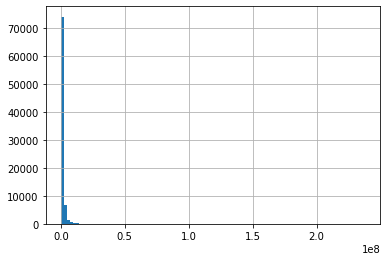

In [37]:
train.price.hist(bins=100)

In [38]:
train[train.price>(1.369000e+06 + (1.369000e+06-1.200000e+04)*1.5)]

bodyType       brand  \
4             внедорожник 5 дв.    CADILLAC   
233     пикап полуторная кабина        FORD   
256        пикап двойная кабина      TOYOTA   
258        пикап двойная кабина    MERCEDES   
268        пикап двойная кабина      TOYOTA   
...                         ...         ...   
227812                  минивэн    MERCEDES   
227998        внедорожник 5 дв.  LAND_ROVER   
228010        внедорожник 5 дв.        AUDI   
228012        внедорожник 5 дв.      TOYOTA   
229785        внедорожник 5 дв.     BENTLEY   

                                                    color engineDisplacement  \
4                                                  чёрный            6.2 LTR   
233                                                 белый            3.5 LTR   
256     : Серый магнетик металлик\nСалон: Черный\n\nДв...            5.7 LTR   
258                                                 серый            2.3 LTR   
268                                                 белый            2.8 LTR   
...                                                   ...                ...   
227812                                             чёрный            2.1 LTR   
227998                                            красный            3.0 LTR   
228010                                              синий            2.0 LTR   
228012                                             чёрный            2.8 LTR   
229785  : Breeze металлик\nСалон: сочетание цветов сал...            4.0 LTR   

       enginePower                                     equipment_dict  \
4          426 N12  {"esp":true,"usb":true,"multi-wheel":true,"ash...   
233        450 N12  {"keyless-entry":true,"climate-control-1":true...   
256        381 N12  {"cruise-control":true,"asr":true,"esp":true,"...   
258        190 N12  {"cruise-control":true,"asr":true,"airbag-driv...   
268        177 N12  {"cruise-control":true,"tinted-glass":true,"es...   
...            ...                                                ...   
227812     190 N12  {"cruise-control":true,"audiosystem-cd":true,"...   
227998     249 N12  {"cruise-control":true,"esp":true,"usb":true,"...   
228010     249 N12  {"tinted-glass":true,"esp":true,"adaptive-ligh...   
228012     177 N12                                                NaN   
229785     550 N12  {"asr":true,"esp":true,"usb":true,"e-adjustmen...   

       fuelType  mileage  modelDate          model_name  ...  productionDate  \
4        бензин    92000       2014            Escalade  ...            2018   
233      бензин     4126       2017               F-150  ...            2020   
256      бензин    18277       2013                 NaN  ...            2014   
258      дизель    72757       2017             X-Класс  ...            2018   
268      дизель    51000       2015               Hilux  ...            2018   
...         ...      ...        ...                 ...  ...             ...   
227812   дизель    84000       2014             V-Класс  ...            2018   
227998   дизель    55000       2017   Range Rover Sport  ...            2018   
228010   бензин    61000       2017                  Q5  ...            2018   
228012   дизель    30000       2017  Land Cruiser Prado  ...            2018   
229785   бензин      160       2020            Bentayga  ...            2021   

                                                super_gen  \
4       {"id":"20226379","name":"IV","ru_name":"4","ye...   
233     {"id":"21148094","name":"XIII Рестайлинг","ru_...   
256     {"id":"20281153","name":"II Рестайлинг","ru_na...   
258     {"id":"20862679","name":"I","ru_name":"1","yea...   
268     {"id":"20555257","name":"VIII","ru_name":"8","...   
...                                                   ...   
227812  {"id":"20109722","name":"II","ru_name":"2","ye...   
227998  {"id":"21123159","name":"II Рестайлинг","ru_na...   
228010  {"id":"20849216","name":"II (FY)","ru_name":"2...   
228012  {"id":"21090216","name":"150 Series Реста

In [39]:
train[train.price>5e+07]

bodyType         brand  \
8370    кабриолет   ROLLS_ROYCE   
11386        купе       FERRARI   
18784     родстер      MERCEDES   
49862        купе   LAMBORGHINI   
66700        купе  ASTON_MARTIN   
110776    лимузин      MERCEDES   

                                                    color engineDisplacement  \
8370    кузова: Arctic White (Белый)\nЦвет салона: Arc...            6.8 LTR   
11386                                             красный            6.3 LTR   
18784                                               серый            5.4 LTR   
49862                                              чёрный            6.5 LTR   
66700                                             зелёный            5.3 LTR   
110776                                             чёрный            6.0 LTR   

       enginePower                                     equipment_dict  \
8370       460 N12                           {"door-sill-panel":true}   
11386      963 N12                                                NaN   
18784      650 N12                                                NaN   
49862      700 N12  {"cruise-control":true,"esp":true,"airbag-driv...   
66700      608 N12                                                NaN   
110776     630 N12  {"e-adjustment-wheel":true,"multi-wheel":true,...   

       fuelType  mileage  modelDate       model_name  ...  productionDate  \
8370     бензин        3       2012          Phantom  ...            2016   
11386    гибрид      500       2013        LaFerrari  ...            2014   
18784    бензин    15000       2003      SLR McLaren  ...            2009   
49862    бензин     6358       2011        Aventador  ...            2012   
66700    бензин     4600       1993       V8 Vantage  ...            1999   
110776   бензин      120       2017  Maybach S-Класс  ...            2018   

                                                super_gen  \
8370    {"id":"20267787","name":"VII Рестайлинг (Serie...   
11386   {"id":"20167622","year_from":2013,"year_to":20...   
18784   {"id":"2307824","year_from":2003,"year_to":200...   
49862   {"id":"7792029","name":"I","ru_name":"1","year...   
66700   {"id":"3473190","name":"II","ru_name":"2","yea...   
110776  {"id":"21037648","name":"I (X222) Рестайлинг",...   

        vehicleTransmission    vendor    Владельцы            date       ПТС  \
8370         автоматическая  EUROPEAN   1 владелец        26 марта  Оригинал   
11386      роботизированная  EUROPEAN   1 владелец       18 января  Оригинал   
18784        автоматическая  EUROPEAN  3 или более       2 августа  Оригинал   
49862      роботизированная       NaN  3 или более         1 марта  Оригинал   
66700          механическая  EUROPEAN  2 владельца  3 октября 2019  Оригинал   
110776       автоматическая  EUROPEAN   1 владелец          8 июня  Оригинал   

        Привод   Руль                city  
8370    задний  Левый            в Москве  
11386   задний  Левый            в Москве  
18784   задний  Левый  в Санкт-Петербурге  
49862   полный  Левый            в Москве  
66700   задний  Левый            в Москве  
110776  задний  Левый  в Санкт-Петербурге  

[6 rows x 22 columns]

In [40]:
train[train['city']==train['city'][1]]

bodyType       brand        color engineDisplacement  \
1                   седан         KIA        белый            1.6 LTR   
2         универсал 5 дв.  VOLKSWAGEN  серебристый            2.0 LTR   
4       внедорожник 5 дв.    CADILLAC       чёрный            6.2 LTR   
42                  седан     RENAULT    пурпурный            1.6 LTR   
43                  седан         VAZ      красный            1.2 LTR   
...                   ...         ...          ...                ...   
229979              седан         VAZ      красный            1.6 LTR   
230212              седан     HYUNDAI       чёрный            2.7 LTR   
230217  внедорожник 5 дв.    MERCEDES       чёрный            1.6 LTR   
230365              седан     HYUNDAI       чёрный            2.7 LTR   
230502  внедорожник 5 дв.      SUBARU        синий            2.5 LTR   

       enginePower                                     equipment_dict  \
1          123 N12  {"glonass":true,"tinted-glass":true,"esp":true...   
2          140 N12                                                NaN   
4          426 N12  {"esp":true,"usb":true,"multi-wheel":true,"ash...   
42          90 N12  {"airbag-passenger":true,"condition":true,"abs...   
43          64 N12                                                NaN   
...            ...                                                ...   
229979      73 N12                                                NaN   
230212     172 N12  {"engine-proof":true,"asr":true,"tinted-glass"...   
230217     156 N12  {"abs":true,"esp":true,"light-cleaner":true,"a...   
230365     172 N12  {"front-centre-armrest":true,"airbag-passenger...   
230502     185 N12  {"asr":true,"tinted-glass":true,"esp":true,"ad...   

       fuelType  mileage  modelDate model_name  ...  productionDate  \
1        бензин   165000       2017        Rio  ...            2018   
2        дизель   251000       2005     Passat  ...            2007   
4        бензин    92000       2014   Escalade  ...            2018   
42       бензин   167000       1995     Megane  ...            1998   
43       бензин   100000       1970       2101  ...            1979   
...         ...      ...        ...        ...  ...             ...   
229979   бензин   179350       1979       2105  ...            2008   
230212   бензин   206000       2001     Sonata  ...            2007   
230217   бензин    35000       2017        GLA  ...            2018   
230365   бензин   206000       2001     Sonata  ...            2007   
230502   бензин    30000       2018   Forester  ...            2020   

                                                super_gen  \
1       {"id":"21028015","name":"IV","ru_name":"4","ye...   
2       {"id":"2309871","name":"B6","year_from":2005,"...   
4       {"id":"20226379","name":"IV","ru_name":"4","ye...   
42      {"id":"3491275","name":"I","ru_name":"1","year...   
43      {"id":"6256978","year_from":1970,"year_to":198...   
...                                                   ...   
229979  {"id":"2307266","year_from":1979,"year_to":201...   
230212  {"id":"2306936","name":"IV (EF) Рестайлинг","r...   
230217  {"id":"20896051","name":"I (X156) Рестайлинг",...   
230365  {"id":"2306936","name":"IV (EF) Рестайлинг","r...   
230502  {"id":"21220292","name":"V","ru_name":"5","yea...   

        vehicleTransmission    vendor    Владельцы        date       ПТС  \
1            автоматическая    KOREAN   1 владелец  11 августа  Оригинал   
2          роботизированная  EUROPEAN  2 владельца  10 августа  Оригинал   
4            автоматическая  AMERICAN  2 владельца  13 августа  Оригинал   
42             механическая  EUROPEAN  3 или более  13 августа  Оригинал   
43             механическая   RUSSIAN  2 владельца  12 августа  Оригинал   
...                     ...       ...          ...         ...       ...   
229979         механическая       NaN  3 или более     25 июля  Оригинал   
230212       автоматическая    KOREAN  3 или более  15 августа  Ориги

Если мы оставим только Москву, наш датасет станет меньше тестового

## Year

Посмотрим на данный признак.

In [41]:
train.year = train.date.apply(lambda x: str(x)[-4:])

In [42]:
train.year.unique()

array(['уста', 'июня', 'арта', 'июля', 'реля', '2018', '2020', 'варя',
       '2017', 'nan', ' мая', 'раля', '2019', '2016', '2015', '2014',
       '2013'], dtype=object)

In [43]:
train.date.isna().sum()

119

In [44]:
train.year = train.year.apply(
        lambda x: 2020 if x == '2020' 
        else 2019 if x == '2019' 
        else 2018 if x == '2018' 
        else 2017 if x == '2017' 
        else 2016 if x == '2016'
        else 2015 if x == '2015' 
        else 2014 if x == '2014' 
        else 2013 if x == '2013' 
        else 2021)

In [45]:
train.year.value_counts()

2021    78102
2020     3030
2019     1995
2018      294
2017       88
2016       27
2015       16
2014        8
2013        1
Name: date, dtype: int64

Оставим в нашей выборке только объявления 2021 года.

In [46]:
train = train[train.year==2021]

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78102 entries, 1 to 230528
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             78102 non-null  object
 1   brand                78102 non-null  object
 2   color                78082 non-null  object
 3   engineDisplacement   78102 non-null  object
 4   enginePower          78102 non-null  object
 5   equipment_dict       59353 non-null  object
 6   fuelType             78102 non-null  object
 7   mileage              78102 non-null  int64 
 8   modelDate            78102 non-null  int64 
 9   model_name           78016 non-null  object
 10  numberOfDoors        78102 non-null  int64 
 11  price                78102 non-null  int64 
 12  productionDate       78102 non-null  int64 
 13  super_gen            78102 non-null  object
 14  vehicleTransmission  78099 non-null  object
 15  vendor               76790 non-null  object
 16  Вла

## Brand

In [48]:
train.brand.isna().sum()

0

Пропущенных значений в признаке нет. Посмотрим на уникальные значения.

In [49]:
train.brand.unique()

array(['KIA', 'VOLKSWAGEN', 'CADILLAC', 'RENAULT', 'VAZ', 'HYUNDAI',
       'NISSAN', 'UAZ', 'PEUGEOT', 'TOYOTA', 'FORD', 'LAND_ROVER',
       'MERCEDES', 'SUBARU', 'SKODA', 'CHEVROLET', 'MITSUBISHI', 'ZAZ',
       'MOSCVICH', 'MAZDA', 'DAEWOO', 'OPEL', 'BMW', 'GAZ', 'AUDI',
       'HONDA', 'DAIHATSU', 'VOLVO', 'DODGE', 'VORTEX', 'ALFA_ROMEO',
       'GEELY', 'CHERY', 'DATSUN', 'MASERATI', 'BENTLEY', 'PORSCHE',
       'CHRYSLER', 'CITROEN', 'FIAT', 'JEEP', 'LEXUS', 'JAGUAR',
       'LAMBORGHINI', 'INFINITI', 'FERRARI', 'TESLA', 'HUMMER', 'ROVER',
       'SSANG_YONG', 'ISUZU', 'MINI', 'LIFAN', 'SUZUKI', 'GREAT_WALL',
       'CHANGAN', 'HAVAL', 'LINCOLN', 'GENESIS', 'SEAT', 'DONGFENG',
       'SMART', 'TAGAZ', 'HAIMA', 'RAVON', 'ACURA', 'MAYBACH', 'GMC',
       'ROLLS_ROYCE', 'MCLAREN', 'ALPINA', 'PONTIAC', 'IRAN_KHODRO',
       'ASTON_MARTIN', 'RAM', 'IG', 'XINKAI', 'LUAZ', 'PROMO_AUTO', 'SMZ',
       'DADI', 'ZX', 'PLYMOUTH', 'BYD', 'SAAB', 'HAFEI', 'DONINVEST',
       'DERWAYS', 'TIAN

In [50]:
train.brand.nunique()

129

Разобъем признак на группы:

In [51]:
premium = ['CADILLAC', 'MASERATI', 'BENTLEY', 'PORSCHE', 'CHRYSLER', 'LEXUS', 
           'JAGUAR', 'LAMBORGHINI', 'INFINITI', 'FERRARI', 'TESLA', 'HUMMER', 
           'MAYBACH', 'ROLLS_ROYCE', 'MCLAREN', 'LOTUS', 'BUGATTI']
econom = ['ZAZ', 'MOSCVICH', 'TAGAZ', 'LUAZ', 'SMZ', 'TATRA']
old = ['LINCOLN', 'PROMO_AUTO', 'PLYMOUTH',
       'OLDSMOBILE', 'WILLIS', 'SIMCA', 'ZIL']

In [52]:
train.brand = train.brand.apply(lambda x: 'PREMIUM' if x in premium else
                               'ECONOM' if x in econom else
                               'OLD' if x in old else x)

In [53]:
train.brand.unique()

array(['KIA', 'VOLKSWAGEN', 'PREMIUM', 'RENAULT', 'VAZ', 'HYUNDAI',
       'NISSAN', 'UAZ', 'PEUGEOT', 'TOYOTA', 'FORD', 'LAND_ROVER',
       'MERCEDES', 'SUBARU', 'SKODA', 'CHEVROLET', 'MITSUBISHI', 'ECONOM',
       'MAZDA', 'DAEWOO', 'OPEL', 'BMW', 'GAZ', 'AUDI', 'HONDA',
       'DAIHATSU', 'VOLVO', 'DODGE', 'VORTEX', 'ALFA_ROMEO', 'GEELY',
       'CHERY', 'DATSUN', 'CITROEN', 'FIAT', 'JEEP', 'ROVER',
       'SSANG_YONG', 'ISUZU', 'MINI', 'LIFAN', 'SUZUKI', 'GREAT_WALL',
       'CHANGAN', 'HAVAL', 'OLD', 'GENESIS', 'SEAT', 'DONGFENG', 'SMART',
       'HAIMA', 'RAVON', 'ACURA', 'GMC', 'ALPINA', 'PONTIAC',
       'IRAN_KHODRO', 'ASTON_MARTIN', 'RAM', 'IG', 'XINKAI', 'DADI', 'ZX',
       'BYD', 'SAAB', 'HAFEI', 'DONINVEST', 'DERWAYS', 'TIANMA', 'FAW',
       'JAC', 'AUBURN', 'LIGIER', 'MITSUOKA', 'BAIC', 'RINSPEED', 'GAC',
       'TATA', 'BRILLIANCE', 'ZOTYE', 'MERCURY', 'DS', 'SATURN', 'HAWTAI',
       'LUXGEN', 'DW_HOWER', 'DACIA', 'TIANYE', 'CHERYEXEED', 'BUICK',
       'HUANGHAI', '

In [54]:
train.brand.value_counts()

VAZ           11004
KIA            5074
HYUNDAI        4808
VOLKSWAGEN     4791
MERCEDES       4463
              ...  
ZIS               1
WANDERER          1
GAC               1
DADI              1
MG                1
Name: brand, Length: 105, dtype: int64

In [55]:
train.brand.value_counts().index[:50]

Index(['VAZ', 'KIA', 'HYUNDAI', 'VOLKSWAGEN', 'MERCEDES', 'TOYOTA', 'BMW',
       'NISSAN', 'FORD', 'RENAULT', 'PREMIUM', 'CHEVROLET', 'AUDI',
       'MITSUBISHI', 'SKODA', 'OPEL', 'MAZDA', 'LAND_ROVER', 'PEUGEOT', 'UAZ',
       'VOLVO', 'HONDA', 'DAEWOO', 'CITROEN', 'SUZUKI', 'GAZ', 'ECONOM',
       'SUBARU', 'CHERY', 'SSANG_YONG', 'LIFAN', 'GREAT_WALL', 'DODGE', 'JEEP',
       'DATSUN', 'GEELY', 'FIAT', 'MINI', 'IG', 'VORTEX', 'HAVAL', 'SMART',
       'RAM', 'GENESIS', 'DAIHATSU', 'SEAT', 'OLD', 'SAAB', 'RAVON', 'ROVER'],
      dtype='object')

Возьмем первые пятьдесят наиболее встречающихся значений, чтобы уменьшить количество признаков, остальным назовем **other**

In [56]:
most_brand = train.brand.value_counts().index[:50]

In [57]:
train.brand = train.brand.apply(lambda x: 'other' if x not in most_brand else x)

In [58]:
train.brand.value_counts()

VAZ           11004
KIA            5074
HYUNDAI        4808
VOLKSWAGEN     4791
MERCEDES       4463
TOYOTA         4064
BMW            3950
NISSAN         3799
FORD           3258
RENAULT        3245
PREMIUM        2880
CHEVROLET      2693
AUDI           2538
MITSUBISHI     2462
SKODA          2365
OPEL           2024
MAZDA          1747
LAND_ROVER     1106
PEUGEOT        1048
UAZ            1038
VOLVO           975
HONDA           941
DAEWOO          748
CITROEN         722
SUZUKI          703
GAZ             570
SUBARU          506
ECONOM          506
CHERY           418
SSANG_YONG      401
other           392
LIFAN           308
GREAT_WALL      301
DODGE           287
JEEP            265
DATSUN          236
GEELY           230
FIAT            226
MINI            171
IG              166
VORTEX           85
HAVAL            82
SMART            80
RAM              74
GENESIS          66
DAIHATSU         60
SEAT             56
OLD              51
SAAB             45
RAVON            38


In [59]:
cat_cols.append('brand')

In [60]:
test.brand.value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

In [61]:
test.brand = test.brand.apply(lambda x: 'PREMIUM' if x in premium else
                               'ECONOM' if x in econom else
                               'OLD' if x in old else x)
test.brand = test.brand.apply(lambda x: 'other' if x not in most_brand else x)

В результате наших преобразований мы получили следующие значения в признаке.

In [62]:
test.brand.value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
PREMIUM       1705
VOLVO         1463
HONDA         1150
Name: brand, dtype: int64

## Vendor

Посмотрим на значения в признаке.

In [63]:
display(pd.DataFrame(train.vendor.value_counts()))
display(train.vendor.count())

vendor
EUROPEAN                                             28432
JAPANESE                                             15639
RUSSIAN                                              14315
KOREAN                                               10511
AMERICAN                                              6175
...                                                    ...
JAPANESE"},"lk_summary":"2.5 AT (231 л.с.), вне...       1
AMERICAN"},"lk_summary":"2.5 AT (150 л.с.), вне...       1
RUSSIAN"},"lk_summary":"1.6 MT (118 л.с.), седа...       1
AMERICAN"},"lk_summary":"1.6 AT (150 л.с.), вне...       1
EUROPEAN"},"lk_summary":"2.0 AMT (180 л.с.), вн...       1

[83 rows x 1 columns]

76790

Видим, что в признаке присутствуют некорректные значения. Избавимся от них. 

In [64]:
train['vendor'] = train['vendor'].astype(str).apply(lambda x: x.split('"}')[0])

In [65]:
display(pd.DataFrame(train.vendor.value_counts()))
display(train.vendor.count())

vendor
EUROPEAN         28456
JAPANESE         15670
RUSSIAN          14324
KOREAN           10528
AMERICAN          6181
CHINESE           1600
nan               1312
VENDOR_UNKNOWN      31

78102

Значения nan и VENDOR_UNKNOWN заменим на значения согласно приведенным ниже спискам.

In [66]:
list_EUROPEAN = train[train['vendor'] == 'EUROPEAN']['brand'].unique()
list_JAPANESE = train[train['vendor'] == 'JAPANESE']['brand'].unique()
list_RUSSIAN = train[train['vendor'] == 'RUSSIAN']['brand'].unique()
list_KOREAN = train[train['vendor'] == 'KOREAN']['brand'].unique()
list_AMERICAN = train[train['vendor'] == 'AMERICAN']['brand'].unique()
list_CHINESE = train[train['vendor'] == 'CHINESE']['brand'].unique()

In [67]:
train['vendor'] = train['brand'].apply(
    lambda x: 'EUROPEAN' if x in list_EUROPEAN else 'JAPANESE' if x in list_JAPANESE 
    else 'RUSSIAN' if x in list_RUSSIAN else 'KOREAN' if x in list_KOREAN else 'AMERICAN' if x in list_AMERICAN 
    else 'CHINESE')

In [68]:
display(pd.DataFrame(train.vendor.value_counts()))
display(train.vendor.count())

vendor
EUROPEAN   36427
RUSSIAN    16308
JAPANESE   14518
KOREAN      5541
AMERICAN    3884
CHINESE     1424

78102

In [69]:
test.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

In [70]:
cat_cols.append('vendor')

## BodyType

In [71]:
train.bodyType.isna().sum()

0

Нулевых значений в признаке нет.

In [72]:
train.bodyType.value_counts()

внедорожник 5 дв.          24800
седан                      23849
хэтчбек 5 дв.               9941
универсал 5 дв.             4855
лифтбек                     2588
компактвэн                  2025
купе                        1985
минивэн                     1836
хэтчбек 3 дв.               1463
внедорожник 3 дв.           1374
пикап двойная кабина        1199
фургон                       978
кабриолет                    300
родстер                      253
купе-хардтоп                 250
седан 2 дв.                  112
микровэн                      85
внедорожник открытый          85
пикап одинарная кабина        35
пикап полуторная кабина       34
седан-хардтоп                 19
тарга                         10
хэтчбек 4 дв.                  9
фастбек                        8
универсал 3 дв.                3
лимузин                        3
спидстер                       3
Name: bodyType, dtype: int64

In [73]:
train.bodyType.unique()

array(['седан', 'универсал 5 дв.', 'внедорожник 5 дв.', 'хэтчбек 5 дв.',
       'внедорожник 3 дв.', 'лифтбек', 'купе', 'хэтчбек 3 дв.',
       'пикап полуторная кабина', 'пикап двойная кабина',
       'пикап одинарная кабина', 'купе-хардтоп', 'компактвэн', 'минивэн',
       'микровэн', 'фургон', 'кабриолет', 'родстер', 'тарга', 'спидстер',
       'внедорожник открытый', 'фастбек', 'седан 2 дв.',
       'универсал 3 дв.', 'седан-хардтоп', 'лимузин', 'хэтчбек 4 дв.'],
      dtype=object)

В признаке присутствует много значений, приведем их к более упорядоченным значениям.

In [74]:
sedan = ['седан', 'универсал 5 дв.', 'хэтчбек 5 дв.', 'хэтчбек 3 дв.', 
         'седан 2 дв.', 'универсал 3 дв.', 'лифтбек', 'хэтчбек 4 дв.', 
         'седан-хардтоп']
jeep = ['внедорожник 5 дв.', 'внедорожник 3 дв.', 'пикап полуторная кабина', 
        'пикап двойная кабина', 'пикап одинарная кабина', 'внедорожник открытый']
coupe = ['купе', 'купе-хардтоп', 'кабриолет', 'родстер', 'тарга', 'спидстер',
         'фастбек', 'лимузин','фаэтон']
van = ['компактвэн', 'минивэн', 'микровэн', 'фургон']

In [75]:
train.bodyType = train.bodyType.apply(lambda x: 1 if x in sedan else
                     2 if x in jeep else
                     3 if x in coupe else
                     4 if x in van
                     else 0)

In [76]:
train.bodyType.value_counts()

1    42839
2    27527
4     4924
3     2812
Name: bodyType, dtype: int64

In [77]:
test.bodyType.value_counts()

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап одинарная кабина         5
пикап полуторная кабина        5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [78]:
test.bodyType = test.bodyType.apply(lambda x: 1 if x in sedan else
                     2 if x in jeep else
                     3 if x in coupe else
                     4 if x in van
                     else 0)

In [79]:
test.bodyType.value_counts()

1    19282
2    12636
4     1588
3     1180
Name: bodyType, dtype: int64

In [80]:
cat_cols.append('bodyType')

## Сolor

In [81]:
train.color.isna().sum()

20

In [82]:
train.color.value_counts()

чёрный                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [83]:
color = train.color.copy()
color = color.apply(lambda x: str(x).lower())
color = color.apply(lambda x: str(x).replace('"', ''))
color = color.apply(lambda x: str(x).replace('/', ''))
color = color.apply(lambda x: str(x).replace(':', ''))
color = color.apply(lambda x: str(x).replace(',', ''))
color = color.apply(lambda x: str(x).replace('|', ''))
color = color.apply(lambda x: str(x).replace('{', ''))
color = color.apply(lambda x: str(x).replace('@', ''))
color = color.apply(lambda x: str(x).replace('}', ''))
color = color.apply(lambda x: str(x)[:30])
base_color = pd.read_csv('../input/colorcsv/color.csv', encoding='windows-1251')

In [84]:
base_color

color
0        Ярко-синий
1        Ярко-синий
2      Ярко-красный
3      Ярко-красный
4      Ярко-красный
..              ...
421         Бежевый
422   Звёздная Пыль
423          Сандал
424   Бронзовый век
425  Слоновая Кость

[426 rows x 1 columns]

Приведем цвета к базовым, оставим 11 самых популярных, остальные назовем **other**

In [85]:
base_color.color = base_color.color.apply(lambda x: str(x).lower())
list_base_color = list(base_color.color)

for i in list_base_color:
    for j in range(len(color)):
        if i in str(color.iloc[j]):
            color.iloc[j] = i

color = color.apply(lambda x: x if len(x)< 20 else 'other')
color.value_counts()

чёрный                16971
белый                 14927
серый                 10679
серебристый            8976
синий                  7372
красный                4437
коричневый             3375
зелёный                3218
other                  2440
бежевый                1762
голубой                1175
фиолетовый              571
пурпурный               559
жёлтый                  555
золотистый              511
оранжевый               489
розовый                  25
nan                      20
сапфир                    8
космос                    6
сочи                      3
кварц                     3
снежная королева          2
вишня                     2
оливковый                 2
белое облако              2
сафари                    2
кристалл                  2
калифорнийский мак        1
персей                    1
жемчуг                    1
мокрый асфальт            1
мурена                    1
чароит                    1
гранат                    1
робин гуд           

In [86]:
color.value_counts().index[:11]
list_color = color.value_counts().index[:11]
color = color.apply(lambda x: x if x in list_color else 'other')
color.value_counts()
train.color = color

In [87]:
cat_cols.append('color')

In [88]:
test.color.isna().sum()

0

In [89]:
test.color.value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

Заменим значения признака на наиболее часто встречающиеся значения.

In [90]:
test.color = test.color.apply(lambda x: x if x in list_color else 'other')

In [91]:
test.color.value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
other           1077
зелёный          952
бежевый          639
голубой          457
Name: color, dtype: int64

## Model_name

In [92]:
display(test.model_name.sample(10), train.model_name.sample(10)) 

19231       VENZA
8799           X5
7808           X7
8438           M5
29776          X3
19144       RAV_4
7623         X6_M
17851    S_KLASSE
31403         S60
17916    S_KLASSE
Name: model_name, dtype: object

1249             5 серии
49491               Ceed
40404               RAV4
31054               Niva
201184                 3
94187     Almera Classic
14414            Octavia
78804               Vito
29818              Doblo
74717              Vesta
Name: model_name, dtype: object

Приведем признак из train к формату test

In [93]:
train.model_name = train.model_name.astype(str).apply(lambda x: x.upper())

In [94]:
train.bodyType.isna().sum()

0

In [95]:
test.bodyType.isna().sum()

0

In [96]:
train.model_name.value_counts()

FOCUS         1585
RIO           1262
SOLARIS       1240
2121 (4X4)    1134
GRANTA        1119
              ... 
CABRIOLET        1
COOLBEAR         1
UP!              1
STARIA           1
NEMO             1
Name: model_name, Length: 1436, dtype: int64

In [97]:
train.model_name.value_counts().index[:100]

Index(['FOCUS', 'RIO', 'SOLARIS', '2121 (4X4)', 'GRANTA', 'OCTAVIA', 'POLO',
       'ASTRA', 'SPORTAGE', 'NIVA', 'VESTA', 'KALINA', 'DUSTER', 'TIGUAN',
       'E-КЛАСС', 'PRIORA', 'PASSAT', 'LARGUS', '2114', 'CEED', 'X-TRAIL',
       'LOGAN', 'QASHQAI', 'CAMRY', '2107', '5 СЕРИИ', 'CRETA', '3 СЕРИИ',
       'OUTLANDER', 'X5', 'PATRIOT', 'SANTA FE', 'RAV4', '2110', 'SORENTO',
       'SANDERO', '2115', 'A6', 'RAPID', 'COROLLA', 'LANCER', 'LAND CRUISER',
       'C-КЛАСС', 'CX-5', 'S-КЛАСС', '6', '3', 'LAND CRUISER PRADO', 'LACETTI',
       'TUCSON', 'OPTIMA', 'TOUAREG', 'NEXIA', 'CERATO', '2112', 'X3', 'GOLF',
       'MONDEO', 'X6', 'RX', 'IX35', 'JETTA', 'MATIZ', 'KAPTUR', 'A4', '2109',
       'KUGA', 'CRUZE', 'AVEO', '2105', 'CAYENNE', 'Q5', 'ALMERA', '2106',
       'LANOS', '2104', 'SOUL', 'XRAY', 'Q7', 'RANGE ROVER', '21099',
       'RANGE ROVER SPORT', 'ELANTRA', 'CR-V', 'A5', 'M-КЛАСС', 'PAJERO',
       '2131 (4X4)', 'GETZ', 'TERRANO', 'C4', 'SONATA', 'ASX', '2111',
       'PARTNER'

Оставим 100 наиболее встречаемых марки автомобилей, остальным присвоим значение **other**

In [98]:
list_model_name = train.model_name.value_counts().index[:100]

In [99]:
train.model_name = train.model_name.apply(lambda x: x if x in list_model_name else 'other')

In [100]:
train.model_name.value_counts()

other           29659
FOCUS            1585
RIO              1262
SOLARIS          1240
2121 (4X4)       1134
                ...  
CORSA             219
7 СЕРИИ           211
L200              211
GRAND VITARA      210
LX                208
Name: model_name, Length: 101, dtype: int64

In [101]:
test.model_name.value_counts()

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
            ... 
MINICA         1
PLATZ          1
RNESSA         1
POLO_GTI       1
OTTI           1
Name: model_name, Length: 544, dtype: int64

In [102]:
test.model_name = test.model_name.apply(lambda x: x if x in list_model_name else 'other')

In [103]:
test.model_name.value_counts()

other        21539
OCTAVIA       1418
LANCER         855
PASSAT         782
A6             757
POLO           724
CAMRY          709
X5             675
A4             626
QASHQAI        609
OUTLANDER      544
ALMERA         502
TIGUAN         491
TOUAREG        469
COROLLA        456
GOLF           424
RAPID          370
JETTA          324
X6             317
PAJERO         306
Q7             302
X3             283
Q5             246
RX             235
A5             211
LX             154
ASX            139
TERRANO        122
L200            90
CORSA            5
PARTNER          2
Name: model_name, dtype: int64

Пропущенных значений в признаке нет.

In [104]:
cat_cols.append('model_name')

## FuelType

In [105]:
train.fuelType.isna().sum()

0

Пропущенных значений в признаке нет, посмотрим на значения признаков.

In [106]:
train.fuelType.value_counts()

бензин     67109
дизель     10536
гибрид       230
электро      196
газ           31
Name: fuelType, dtype: int64

In [107]:
test.fuelType.isna().sum()

0

In [108]:
test.fuelType.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

Все значения в норме.

In [109]:
cat_cols.append('fuelType')

## NumberOfDoors

In [110]:
train.numberOfDoors.isna().sum()

0

In [111]:
train.numberOfDoors.value_counts()

5    45717
4    26185
3     3128
2     3068
0        4
Name: numberOfDoors, dtype: int64

In [112]:
train[train.numberOfDoors==0]

bodyType   brand    color engineDisplacement enginePower  \
8477           2  ECONOM  зелёный            1.2 LTR      37 N12   
12798          3   other   чёрный            2.0 LTR     250 N12   
113702         2  ECONOM  зелёный            1.2 LTR      37 N12   
115725         3     OLD  красный            1.5 LTR      44 N12   

                                           equipment_dict fuelType  mileage  \
8477                                                  NaN   бензин    30000   
12798   {"13-inch-wheels":true,"steering-wheel-gear-sh...   бензин     2644   
113702                                                NaN   бензин    25000   
115725                                                NaN   бензин    23000   

        modelDate model_name  ...  productionDate  \
8477         1965      other  ...            1986   
12798        2009      other  ...            2010   
113702       1965      other  ...            1987   
115725       1964      other  ...            1967   

                                                super_gen  \
8477    {"id":"20351791","year_from":1965,"year_to":19...   
12798   {"id":"21295769","name":"I","ru_name":"1","yea...   
113702  {"id":"20351791","year_from":1965,"year_to":19...   
115725  {"id":"22980796","year_from":1964,"price_segme...   

        vehicleTransmission    vendor    Владельцы        date       ПТС  \
8477           механическая  EUROPEAN  3 или более   24 апреля  Дубликат   
12798      роботизированная  EUROPEAN  2 владельца  24 февраля  Оригинал   
113702         механическая  EUROPEAN  2 владельца   24 апреля  Оригинал   
115725         механическая   RUSSIAN  2 владельца      25 мая  Оригинал   

        Привод   Руль                city  
8477    полный  Левый           в Покрове  
12798   задний  Левый            в Москве  
113702  полный  Левый  в Санкт-Петербурге  
115725  задний  Левый  в Санкт-Петербурге  

[4 rows x 22 columns]

Как мы видим, ноль дверей не является ошибкой в данных

In [113]:
test.numberOfDoors.isna().sum()

0

In [114]:
test.numberOfDoors.value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

In [115]:
num_cols.append('numberOfDoors')

## VehicleTransmission

In [116]:
train.vehicleTransmission.isna().sum()

3

In [117]:
train.dropna(subset=['vehicleTransmission'], inplace=True)

In [118]:
train.vehicleTransmission.value_counts()

механическая        33938
автоматическая      33581
роботизированная     6021
вариатор             4559
Name: vehicleTransmission, dtype: int64

In [119]:
test.vehicleTransmission.isna().sum()

0

In [120]:
test.vehicleTransmission.value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

Оставшиеся значения в train и test находятся в одном диапозоне значений.

In [121]:
cat_cols.append('vehicleTransmission')

## ПТС

In [122]:
train['ПТС'].isna().sum()

116

In [123]:
test['ПТС'].isna().sum()

1

In [124]:
train['ПТС'].value_counts()

Оригинал    68041
Дубликат     9942
Name: ПТС, dtype: int64

Заменим пропуски значением 'Дубликат', т.к. оригинал является приоритетным значением и всегда указывается

In [125]:
train['ПТС'].fillna('Дубликат', inplace=True)
test['ПТС'].fillna('Дубликат', inplace=True)

In [126]:
cat_cols.append('ПТС')

## Владельцы

In [127]:
train['Владельцы'].isna().sum()

116

In [128]:
test['Владельцы'].isna().sum()

0

In [129]:
train['Владельцы'].value_counts()

3 или более    31394
1 владелец     27798
2 владельца    18791
Name: Владельцы, dtype: int64

Заменим пропуски наименее приоритетным значением

In [130]:
train['Владельцы'].fillna('3 или более', inplace=True)

In [131]:
cat_cols.append('Владельцы')

## Привод

In [132]:
train['Привод'].isna().sum()

116

In [133]:
test['Привод'].isna().sum()

0

In [134]:
train['Привод'].value_counts()

передний    43387
полный      27568
задний       7028
Name: Привод, dtype: int64

Заменим пропуски медианным значением

In [135]:
train['Привод'].fillna('передний', inplace=True)

In [136]:
cat_cols.append('Привод')

## super_gen

Со временем сайт поменял наполняемость данного признака, и сейчас он не совпадает с тестовым, поэтому бесполезен

## equipment_dict

In [137]:
train.equipment_dict.value_counts()

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  393
{"alarm":true}                                                                                                                                                                    

In [138]:
test.equipment_dict.value_counts()

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [139]:
train.equipment_dict.isna().sum()

18747

In [140]:
test.equipment_dict.isna().sum()

9996

Заменим пропуски значением отсутствующих данных.
Вытащим из признака список оборудования.
Для каждого значения посчитаем общее количество оборудования, установленного на автомобиль.

In [141]:
true = 0

In [142]:
# заполняем пропукски
train.equipment_dict.fillna('no_data', inplace=True)

In [143]:
equip_dict = {}

In [144]:
for i in range(len(train.equipment_dict)):
    try:
        res = eval(train.equipment_dict.iloc[i])    # если возможно(много мусора в данных) создаем словарь оборудования
        equip_dict.update(res)                      # создаем общий словарь всего оборудования 
        train.equipment_dict.iloc[i] = list(res.keys())  # преобразуем в список оборудования
    except: train.equipment_dict.iloc[i] = list(['no_data'])   # если в данных мусор, заменяем на значение отсутствия данных

In [145]:
len(list(equip_dict.keys()))

181

In [146]:
test.equipment_dict.fillna('no_data', inplace=True)
for i in range(len(test.equipment_dict)):
    try:
        res = eval(test.equipment_dict.iloc[i])
        equip_dict.update(res)
        test.equipment_dict.iloc[i] = list(res.keys())
    except: test.equipment_dict.iloc[i] = list(['no_data'])

In [147]:
len(list(equip_dict.keys()))

287

In [148]:
# создадим общий список оборудования
list_equip = list(equip_dict.keys())

In [149]:
# создадим новый признак количество оборудования на автомобиле
train['count_equip'] = 0
test['count_equip'] = 0

In [150]:
train.count_equip = train.equipment_dict.apply(lambda x: len(list(set(list_equip) & set(x))))

In [151]:
train.count_equip.value_counts()

0      18862
1       2931
2       1563
13      1367
12      1352
       ...  
123        2
107        2
109        1
106        1
108        1
Name: count_equip, Length: 113, dtype: int64

In [152]:
test.count_equip = test.equipment_dict.apply(lambda x: len(list(set(list_equip) & set(x))))

## Объединим наши датасеты

In [153]:
columns = ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'model_name', 'numberOfDoors',
           'productionDate', 'vehicleTransmission', 'engineDisplacement',
           'enginePower', 'mileage', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'count_equip']

In [154]:
cars_train = train[columns]
cars_test = test[columns]

Ставим метки 'sample'= 1 or 0 для различения train и test и склеиваем выбранные столбцы.
Назовем полученный датасет cars, он будет использоваться для исследовательского анализа признаков(EDA)

In [155]:
cars_train['sample'] = 1
cars_test['sample'] = 0
cars = cars_train.append(cars_test, ignore_index=True, sort=False)

# Целевая переменная
y = train['price']
y = y/1.3

Цены за год по данным Автостат увеличились на тридцать процентов, уменьшим целевую переменную на эту величину

In [156]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112785 entries, 0 to 112784
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             112785 non-null  int64 
 1   brand                112785 non-null  object
 2   color                112785 non-null  object
 3   fuelType             112785 non-null  object
 4   modelDate            112785 non-null  int64 
 5   model_name           112785 non-null  object
 6   numberOfDoors        112785 non-null  int64 
 7   productionDate       112785 non-null  int64 
 8   vehicleTransmission  112785 non-null  object
 9   engineDisplacement   112785 non-null  object
 10  enginePower          112785 non-null  object
 11  mileage              112785 non-null  int64 
 12  vendor               112785 non-null  object
 13  ПТС                  112785 non-null  object
 14  Владельцы            112785 non-null  object
 15  Привод               112785 non-nu

Сразу заметим, что два категориальных признака - 'enginePower' и 'engineDisplacement' по сути являются числовыми, принимая значения в своих числовых диапазонах. Понятно также то, что цена автомобиля растет в зависимости от роста мощности двигателя или его объема. Поэтому уже на этапе анализа сделаем эти признаки числовыми.

In [157]:
# Количество уникальных значений в этих признаках достаточно большое
print(cars['enginePower'].nunique(), cars['engineDisplacement'].nunique())

445 69


## Часть 2. EDA

## engineDisplacement

In [158]:
cars.engineDisplacement.isna().sum()

0

In [159]:
cars['engineDisplacement'].value_counts()

1.6 LTR    26381
2.0 LTR    22213
3.0 LTR     8650
1.8 LTR     7858
1.4 LTR     6317
           ...  
0.6 LTR        4
7.5 LTR        1
8.4 LTR        1
8.2 LTR        1
8.3 LTR        1
Name: engineDisplacement, Length: 69, dtype: int64

In [160]:
cars[cars['engineDisplacement']=='LTR']

bodyType    brand    color fuelType  modelDate model_name  \
463           2  PREMIUM    серый  электро       2015      other   
1038          1  PREMIUM    серый  электро       2017      other   
1067          1  PREMIUM    синий  электро       2017      other   
1739          1   NISSAN    синий  электро       2017      other   
3432          1  PREMIUM  красный  электро       2012      other   
...         ...      ...      ...      ...        ...        ...   
76123         1  PREMIUM   чёрный  электро       2017      other   
76229         1  PREMIUM    other  электро       2017      other   
77600         1    other    белый  электро       2020      other   
77669         1      BMW   чёрный  электро       2013      other   
77873         1      VAZ  бежевый  электро       2012      other   

       numberOfDoors  productionDate vehicleTransmission engineDisplacement  \
463                5            2017      автоматическая                LTR   
1038               4            2018      автоматическая                LTR   
1067               4            2018      автоматическая                LTR   
1739               5            2018      автоматическая                LTR   
3432               5            2014      автоматическая                LTR   
...              ...             ...                 ...                ...   
76123              4            2020      автоматическая                LTR   
76229              4            2020      автоматическая                LTR   
77600              4            2021      автоматическая                LTR   
77669              5            2017      автоматическая                LTR   
77873              5            2012      автоматическая                LTR   

      enginePower  mileage    vendor       ПТС    Владельцы    Привод  \
463       762 N12    19000  EUROPEAN  Оригинал  2 владельца    полный   
1038      462 N12    59000  EUROPEAN  Оригинал   1 владелец    полный   
1067      462 N12    15150  EUROPEAN  Оригинал   1 владелец    полный   
1739      150 N12    46245  JAPANESE  Оригинал   1 владелец  передний   
3432      422 N12    61000  EUROPEAN  Оригинал   1 владелец    задний   
...           ...      ...       ...       ...          ...       ...   
76123     351 N12    10000  EUROPEAN  Оригинал   1 владелец    полный   
76229     351 N12    10000  EUROPEAN  Оригинал   1 владелец    полный   
77600     267 N12     6500  EUROPEAN  Оригинал   1 владелец    задний   
77669     170 N12    63385  EUROPEAN  Оригинал   1 владелец    задний   
77873      82 N12    32000   RUSSIAN  Оригинал  2 владельца  передний   

       count_equip  sample  
463            112       1  
1038            62       1  
1067             0       1  
1739            23       1  
3432            48       1  
...            ...     ...  
76123           70       1  
76229           70       1  
77600           32       1  
77669           24       1  
77873           11       1  

[196 rows x 18 columns]

Приведем признак к числовому значению.

In [161]:
cars[cars['engineDisplacement']=='LTR'].fuelType.value_counts()

электро    196
Name: fuelType, dtype: int64

Ноль в литраже не является ошибкой, это электромобили

In [162]:
cars['engineDisplacement'] = cars['engineDisplacement'].apply(lambda x: '0 LTR' if x == 'LTR' or x==' LTR' else x)

In [163]:
cars['engineDisplacement'] = cars['engineDisplacement'].apply(lambda x: x.split(' ')[0] if ' ' in x else x[:-4])

In [164]:
cars['engineDisplacement'] = cars['engineDisplacement'].str.strip().astype(np.float)

In [165]:
cars['engineDisplacement'] 

0         1.6
1         2.0
2         1.4
3         6.2
4         1.6
         ... 
112780    1.6
112781    2.0
112782    2.5
112783    2.0
112784    3.0
Name: engineDisplacement, Length: 112785, dtype: float64

In [166]:
cars['engineDisplacement'].describe()

count    112785.000000
mean          2.166368
std           0.891554
min           0.000000
25%           1.600000
50%           2.000000
75%           2.500000
max           8.400000
Name: engineDisplacement, dtype: float64

In [167]:
num_cols.append('engineDisplacement')

## EnginePower

In [168]:
cars.enginePower.isna().sum()

0

In [169]:
cars['enginePower'].value_counts()

150 N12    7449
249 N12    4255
140 N12    2868
105 N12    2801
110 N12    2543
           ... 
481 N12       1
514 N12       1
364 N12       1
795 N12       1
589 N12       1
Name: enginePower, Length: 445, dtype: int64

Также приведем признак к числовому значению.

In [170]:
cars['enginePower'] = cars['enginePower'].apply(lambda x: float(x.split(' ')[0]))

In [171]:
cars['enginePower']

0         123.0
1         140.0
2         125.0
3         426.0
4          85.0
          ...  
112780    136.0
112781    190.0
112782    170.0
112783    184.0
112784    235.0
Name: enginePower, Length: 112785, dtype: float64

In [172]:
cars['enginePower'].describe()

count    112785.000000
mean        163.420100
std          87.799342
min          10.000000
25%         105.000000
50%         143.000000
75%         190.000000
max        1020.000000
Name: enginePower, dtype: float64

In [173]:
num_cols.append('enginePower')

## modelDate

In [174]:
cars.modelDate.isna().sum()

0

In [175]:
cars['modelDate'].describe()

count    112785.000000
mean       2007.285047
std           8.956806
min        1904.000000
25%        2004.000000
50%        2009.000000
75%        2014.000000
max        2021.000000
Name: modelDate, dtype: float64

In [176]:
num_cols.append('modelDate')

## productionDate

In [177]:
cars.productionDate.isna().sum()

0

In [178]:
cars['productionDate'].describe()

count    112785.000000
mean       2010.254192
std           7.560450
min        1904.000000
25%        2007.000000
50%        2012.000000
75%        2016.000000
max        2021.000000
Name: productionDate, dtype: float64

In [179]:
num_cols.append('productionDate')

## mileage

In [180]:
cars.mileage.isna().sum()

0

In [181]:
cars['mileage'].describe()

count     112785.000000
mean      145156.085632
std        96786.794975
min            1.000000
25%        76000.000000
50%       131500.000000
75%       195722.000000
max      1000000.000000
Name: mileage, dtype: float64

In [182]:
cars[(cars['mileage']<1000)&(cars['sample']==1)&(cars['productionDate']==2021)]

bodyType     brand   color fuelType  modelDate    model_name  \
285           4       KIA  чёрный   дизель       2020         other   
356           3   PREMIUM   синий   бензин       2018         other   
467           2       UAZ  чёрный   бензин       2016       PATRIOT   
1158          2     SKODA  чёрный   бензин       2016         other   
1535          2  MERCEDES  чёрный   дизель       2018         other   
...         ...       ...     ...      ...        ...           ...   
76908         2    TOYOTA  чёрный   бензин       2021  LAND CRUISER   
77149         1  MERCEDES   other   дизель       2020       S-КЛАСС   
77250         2    TOYOTA  чёрный   бензин       2013         other   
77454         4       KIA  чёрный   дизель       2020         other   
78088         2   PREMIUM   other   бензин       2020         other   

       numberOfDoors  productionDate vehicleTransmission  engineDisplacement  \
285                5            2021      автоматическая                 2.2   
356                2            2021    роботизированная                 3.0   
467                5            2021      автоматическая                 2.7   
1158               5            2021    роботизированная                 1.4   
1535               5            2021      автоматическая                 2.0   
...              ...             ...                 ...                 ...   
76908              5            2021      автоматическая                 3.5   
77149              4            2021      автоматическая                 2.9   
77250              4            2021      автоматическая                 5.7   
77454              5            2021      автоматическая                 2.2   
78088              5            2021      автоматическая                 4.0   

       enginePower  mileage    vendor       ПТС   Владельцы    Привод  \
285          199.0       23    KOREAN  Оригинал  1 владелец  передний   
356          450.0      415  EUROPEAN  Оригинал  1 владелец    полный   
467          150.0       20   RUSSIAN  Оригинал  1 владелец    полный   
1158         150.0      686  EUROPEAN  Оригинал  1 владелец  передний   
1535         245.0      435  EUROPEAN  Оригинал  1 владелец    полный   
...            ...      ...       ...       ...         ...       ...   
76908        415.0       10  JAPANESE  Оригинал  1 владелец    полный   
77149        249.0       33  EUROPEAN  Оригинал  1 владелец    полный   
77250        381.0        9  JAPANESE  Оригинал  1 владелец    полный   
77454        199.0       23    KOREAN  Оригинал  1 владелец  передний   
78088        550.0      160  EUROPEAN  Оригинал  1 владелец    полный   

       count_equip  sample  
285              1       1  
356             78       1  
467             49       1  
1158            33       1  
1535             1       1  
...            ...     ...  
76908           87       1  
77149           71       1  
77250           56       1  
77454            1       1  
78088           64       1  

[590 rows x 18 columns]

In [183]:
cars[(cars['mileage']<1000)&(cars['sample']==1)&(cars['productionDate']<2020)]

bodyType     brand    color fuelType  modelDate model_name  \
360           3   PREMIUM   чёрный   бензин       2016      other   
1605          1  MERCEDES   чёрный   дизель       2017    S-КЛАСС   
2392          2       UAZ    белый   бензин       2016    PATRIOT   
4640          2     MAZDA    белый   бензин       2019      other   
6291          1  MERCEDES    белый   бензин       2017    S-КЛАСС   
...         ...       ...      ...      ...        ...        ...   
73807         2  MERCEDES    белый   бензин       2015      other   
73872         1      OPEL    серый   бензин       2008      other   
75847         1       VAZ  зелёный   бензин       1982       2107   
76353         2     MAZDA    белый   бензин       2019      other   
76648         2       GAZ  зелёный   бензин       1953      other   

       numberOfDoors  productionDate vehicleTransmission  engineDisplacement  \
360                2            2019    роботизированная                 6.5   
1605               4            2019      автоматическая                 2.9   
2392               5            2018        механическая                 2.7   
4640               5            2019      автоматическая                 2.0   
6291               4            2019      автоматическая                 4.0   
...              ...             ...                 ...                 ...   
73807              5            2017      автоматическая                 4.0   
73872              5            2011        механическая                 1.6   
75847              4            2005        механическая                 1.6   
76353              5            2019      автоматическая                 2.0   
76648              4            1969        механическая                 2.1   

       enginePower  mileage    vendor       ПТС    Владельцы    Привод  \
360          770.0      792  EUROPEAN  Оригинал   1 владелец    полный   
1605         249.0      917  EUROPEAN  Оригинал   1 владелец    полный   
2392         135.0        6   RUSSIAN  Оригинал   1 владелец    полный   
4640         150.0      390  JAPANESE  Оригинал   1 владелец  передний   
6291         469.0       68  EUROPEAN  Оригинал   1 владелец    полный   
...            ...      ...       ...       ...          ...       ...   
73807        422.0      100  EUROPEAN  Оригинал   1 владелец    полный   
73872        180.0      185  EUROPEAN  Оригинал  3 или более  передний   
75847         75.0      666   RUSSIAN  Оригинал  2 владельца    задний   
76353        150.0      390  JAPANESE  Оригинал   1 владелец  передний   
76648         55.0       12   RUSSIAN  Дубликат  2 владельца    полный   

       count_equip  sample  
360              0       1  
1605            51       1  
2392            28       1  
4640            72       1  
6291            14       1  
...            ...     ...  
73807            0       1  
73872            0       1  
75847            0       1  
76353           72       1  
76648            0       1  

[80 rows x 18 columns]

In [184]:
cars[(cars['mileage']<1000) & (cars['sample']==0)&(cars['productionDate']<2020)]

bodyType       brand        color fuelType  modelDate model_name  \
78368          1       SKODA   коричневый   бензин       2017      RAPID   
80210          1       SKODA        белый   бензин       2017      RAPID   
80849          2        AUDI        синий   бензин       2017         Q5   
82396          1        AUDI       чёрный   бензин       1994         A6   
83340          2        AUDI        белый  электро       2018      other   
83484          2       HONDA       чёрный   бензин       2012      other   
83956          2       HONDA        белый   бензин       2016      other   
84125          1       HONDA      красный   бензин       1989      other   
85804          2         BMW       чёрный   дизель       2018      other   
85818          3         BMW        белый   гибрид       2017      other   
86985          1         BMW       чёрный   дизель       2015      other   
87022          3         BMW        other   бензин       2005      other   
87082          1         BMW       чёрный   дизель       2019      other   
87526          2         BMW       чёрный   дизель       2018         X5   
88073          1         BMW        белый   дизель       2015      other   
88966          1         BMW        синий   бензин       2018      other   
90078          1      NISSAN  серебристый   бензин       1983      other   
91592          1      NISSAN      красный   бензин       2018      other   
93509          4    MERCEDES       чёрный   дизель       2014      other   
93523          4    MERCEDES       чёрный   дизель       2014      other   
93541          4    MERCEDES       чёрный   дизель       2014      other   
93571          4    MERCEDES        синий   дизель       2014      other   
93751          4    MERCEDES       чёрный   дизель       2014      other   
93784          2    MERCEDES        белый   бензин       2019      other   
93855          2    MERCEDES      бежевый   бензин       2015      other   
94170          4    MERCEDES       чёрный   дизель       2014      other   
94188          2    MERCEDES       чёрный   бензин       2008      other   
94241          1    MERCEDES       чёрный   бензин       2018      other   
94296          2    MERCEDES       чёрный   бензин       2018      other   
94386          2    MERCEDES       чёрный   дизель       2018      other   
94394          1    MERCEDES        серый   бензин       2019      other   
94500          2    MERCEDES       чёрный   бензин       2019      other   
94620          2    MERCEDES       чёрный   бензин       2018      other   
94676          4    MERCEDES       чёрный   дизель       2014      other   
94771          1    MERCEDES       чёрный   бензин       2018      other   
94910          3    MERCEDES        белый   бензин       2016      other   
94990          1    MERCEDES      красный   бензин       1936      other   
95382          3    MERCEDES        синий   бензин       2011      other   
96922          1    MERCEDES       чёрный   бензин       2016      other   
97601          2      TOYOTA       чёрный   бензин       2015      other   
97651          4      TOYOTA       чёрный   бензин       2017      other   
97755          2      TOYOTA       чёрный   бензин       2017      other   
97862          2      TOYOTA        белый   дизель       2007      other   
97887          4      TOYOTA       чёрный   бензин       2010      other   
98058          1      TOYOTA        other   бензин       1998      other   
98159          2      TOYOTA       чёрный   дизель       2015      other   
100656         1     PREMIUM       чёрный   бензин       2012      other   
101292         2  VOLKSWAGEN  серебристый   дизель       2016      other   
101377         4  VOLKSWAGEN        серый   дизель       2015      other   
104340         1  VOLKSWAGEN        белый   бензин       2014       POLO   
106871         1  MITSUBISHI      красный   бензин       1995     LANCER   
110767         1      NISSAN       чёрный  электро      

Выбросы в числовых колонках вляются значимыми, кроме колонки пробега. Но идентифицировать эти выбросы невозможно.
Единственное, что можно предположить, что пробег менее 1000 указан в тысячах километров.

In [185]:
cars.mileage = cars.mileage.apply(lambda x: x if x>=1000 else x*1000)

In [186]:
num_cols.append('mileage')

Посмотрим на выбросы в числовых данных

In [187]:
for i in num_cols:
    print(i)
    outliers(cars[i])
    print(cars[i].min(),cars[i].max())
    print()

numberOfDoors
25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].
0 5

engineDisplacement
25-й перцентиль: 1.6, 75-й перцентиль: 2.5, IQR: 0.8999999999999999,  Границы выбросов: [0.2500000000000002, 3.8499999999999996].
0.0 8.4

enginePower
25-й перцентиль: 105.0, 75-й перцентиль: 190.0, IQR: 85.0,  Границы выбросов: [-22.5, 317.5].
10.0 1020.0

modelDate
25-й перцентиль: 2004.0, 75-й перцентиль: 2014.0, IQR: 10.0,  Границы выбросов: [1989.0, 2029.0].
1904 2021

productionDate
25-й перцентиль: 2007.0, 75-й перцентиль: 2016.0, IQR: 9.0,  Границы выбросов: [1993.5, 2029.5].
1904 2021

mileage
25-й перцентиль: 77000.0, 75-й перцентиль: 196708.0, IQR: 119708.0,  Границы выбросов: [-102562.0, 376270.0].
1000 1000000



Выбросов немало, избавимся от них, припавняв к ближайшему значению

In [188]:
cars[cars.engineDisplacement>3.85]

bodyType      brand    color fuelType  modelDate model_name  \
3              2    PREMIUM   чёрный   бензин       2014      other   
121            2  CHEVROLET    белый   бензин       1998      other   
202            2     TOYOTA    серый   бензин       2013      other   
217            3    PREMIUM  красный   бензин       2007      other   
222            3    PREMIUM    синий   бензин       2011      other   
...          ...        ...      ...      ...        ...        ...   
112741         2    PREMIUM   чёрный   бензин       2007         LX   
112761         1        BMW  бежевый   бензин       2009      other   
112769         2        BMW   чёрный   бензин       2003         X5   
112772         1        BMW   чёрный   бензин       2005      other   
112773         1        BMW    белый   бензин       2008      other   

        numberOfDoors  productionDate vehicleTransmission  engineDisplacement  \
3                   5            2018      автоматическая                 6.2   
121                 5            1998      автоматическая                 4.3   
202                 4            2014      автоматическая                 5.7   
217                 2            2008      автоматическая                 4.2   
222                 2            2013      автоматическая                 4.0   
...               ...             ...                 ...                 ...   
112741              5            2011      автоматическая                 5.7   
112761              4            2010      автоматическая                 4.4   
112769              5            2005      автоматическая                 4.4   
112772              4            2005      автоматическая                 4.8   
112773              4            2011      автоматическая                 4.4   

        enginePower  mileage    vendor       ПТС    Владельцы    Привод  \
3             426.0    92000  EUROPEAN  Оригинал  2 владельца    полный   
121           193.0   210000   RUSSIAN  Оригинал  2 владельца    полный   
202           381.0    18277  JAPANESE  Дубликат  3 или более  передний   
217           405.0    14000  EUROPEAN  Оригинал  2 владельца    задний   
222           507.0    95000  EUROPEAN  Оригинал  2 владельца    полный   
...             ...      ...       ...       ...          ...       ...   
112741        367.0   484000  JAPANESE  Оригинал   1 владелец    полный   
112761        407.0   191000  EUROPEAN  Оригинал  2 владельца    задний   
112769        320.0   250000  EUROPEAN  Дубликат  3 или более    полный   
112772        367.0   239000  EUROPEAN  Оригинал   1 владелец    задний   
112773        407.0   121276  EUROPEAN  Оригинал  3 или более    полный   

        count_equip  sample  
3                66       1  
121               0       1  
202              53       1  
217               0       1  
222              73       1  
...             ...     ...  
112741           78       0  
112761            0       0  
112769           39       0  
112772            0       0  
112773            0       0  

[6475 rows x 18 columns]

In [189]:
cars[cars.engineDisplacement>5]

bodyType      brand    color fuelType  modelDate model_name  \
3              2    PREMIUM   чёрный   бензин       2014      other   
202            2     TOYOTA    серый   бензин       2013      other   
246            3  CHEVROLET  красный   бензин       1958      other   
360            3    PREMIUM   чёрный   бензин       2016      other   
361            3   MERCEDES  красный   бензин       2012      other   
...          ...        ...      ...      ...        ...        ...   
112330         3   MERCEDES    белый   бензин       2006      other   
112630         2     NISSAN    белый   бензин       2010      other   
112642         2    PREMIUM    белый   бензин       2014      other   
112731         2    PREMIUM    серый   бензин       2012         LX   
112741         2    PREMIUM   чёрный   бензин       2007         LX   

        numberOfDoors  productionDate vehicleTransmission  engineDisplacement  \
3                   5            2018      автоматическая                 6.2   
202                 4            2014      автоматическая                 5.7   
246                 2            1959      автоматическая                 5.7   
360                 2            2019    роботизированная                 6.5   
361                 2            2014      автоматическая                 5.5   
...               ...             ...                 ...                 ...   
112330              2            2010      автоматическая                 5.5   
112630              5            2011      автоматическая                 5.6   
112642              5            2017      автоматическая                 5.6   
112731              5            2014      автоматическая                 5.7   
112741              5            2011      автоматическая                 5.7   

        enginePower  mileage    vendor       ПТС    Владельцы    Привод  \
3             426.0    92000  EUROPEAN  Оригинал  2 владельца    полный   
202           381.0    18277  JAPANESE  Дубликат  3 или более  передний   
246           253.0    65000   RUSSIAN  Оригинал  2 владельца    задний   
360           770.0   792000  EUROPEAN  Оригинал   1 владелец    полный   
361           421.0    23900  EUROPEAN  Оригинал  3 или более    задний   
...             ...      ...       ...       ...          ...       ...   
112330        388.0   123460  EUROPEAN  Оригинал  3 или более    полный   
112630        405.0   157500  JAPANESE  Оригинал  2 владельца    полный   
112642        405.0    57000  JAPANESE  Оригинал  2 владельца    полный   
112731        367.0    88590  JAPANESE  Оригинал   1 владелец    полный   
112741        367.0   484000  JAPANESE  Оригинал   1 владелец    полный   

        count_equip  sample  
3                66       1  
202              53       1  
246               0       1  
360               0       1  
361              59       1  
...             ...     ...  
112330            0       0  
112630            0       0  
112642           68       0  
112731           90       0  
112741           78       0  

[2081 rows x 18 columns]

In [190]:
cars[cars.engineDisplacement>6]

bodyType     brand        color fuelType  modelDate model_name  \
3              2   PREMIUM       чёрный   бензин       2014      other   
360            3   PREMIUM       чёрный   бензин       2016      other   
367            3   PREMIUM        синий   бензин       2005      other   
793            2   PREMIUM       чёрный   бензин       2014      other   
1381           2   PREMIUM       чёрный   бензин       2006      other   
...          ...       ...          ...      ...        ...        ...   
109618         3  MERCEDES        серый   бензин       2006      other   
109753         3  MERCEDES        синий   бензин       2006      other   
109853         2  MERCEDES  серебристый   бензин       2006      other   
109914         3  MERCEDES      красный   бензин       2010      other   
110013         2  MERCEDES       чёрный   бензин       2006      other   

        numberOfDoors  productionDate vehicleTransmission  engineDisplacement  \
3                   5            2018      автоматическая                 6.2   
360                 2            2019    роботизированная                 6.5   
367                 2            2007      автоматическая                 6.8   
793                 5            2019      автоматическая                 6.2   
1381                5            2013      автоматическая                 6.2   
...               ...             ...                 ...                 ...   
109618              2            2008      автоматическая                 6.2   
109753              2            2008      автоматическая                 6.2   
109853              5            2007      автоматическая                 6.2   
109914              2            2014    роботизированная                 6.2   
110013              5            2007      автоматическая                 6.2   

        enginePower  mileage    vendor       ПТС    Владельцы  Привод  \
3             426.0    92000  EUROPEAN  Оригинал  2 владельца  полный   
360           770.0   792000  EUROPEAN  Оригинал   1 владелец  полный   
367           457.0    11800  EUROPEAN  Оригинал   1 владелец  задний   
793           426.0    40000  EUROPEAN  Оригинал   1 владелец  полный   
1381          409.0   135000  EUROPEAN  Дубликат  3 или более  полный   
...             ...      ...       ...       ...          ...     ...   
109618        525.0    88840  EUROPEAN  Оригинал  3 или более  задний   
109753        525.0     4242  EUROPEAN  Оригинал  2 владельца  задний   
109853        510.0   188000  EUROPEAN  Оригинал   1 владелец  полный   
109914        591.0     4800  EUROPEAN  Оригинал  3 или более  задний   
110013        510.0   177000  EUROPEAN  Оригинал  3 или более  полный   

        count_equip  sample  
3                66       1  
360               0       1  
367              28       1  
793              88       1  
1381              0       1  
...             ...     ...  
109618           31       0  
109753            1       0  
109853           64       0  
109914           50       0  
110013            0       0  

[358 rows x 18 columns]

In [191]:
cars[cars.engineDisplacement>3.85].engineDisplacement = 4

In [192]:
cars[cars.modelDate<1989]

bodyType     brand       color fuelType  modelDate model_name  \
37             1       VAZ     красный   бензин       1970      other   
41             1       VAZ     красный   бензин       1984       2104   
50             1       VAZ       белый   бензин       1979       2105   
52             1       VAZ      чёрный   бензин       1979       2105   
54             1    ECONOM  коричневый   бензин       1976      other   
...          ...       ...         ...      ...        ...        ...   
112223         1     VOLVO     зелёный   бензин       1982      other   
112292         1  MERCEDES     бежевый   бензин       1972      other   
112339         1  MERCEDES     красный   бензин       1975      other   
112691         1    TOYOTA       белый   бензин       1987      other   
112754         1       BMW     зелёный   бензин       1987      other   

        numberOfDoors  productionDate vehicleTransmission  engineDisplacement  \
37                  4            1979        механическая                 1.2   
41                  5            2001        механическая                 1.6   
50                  4            2008        механическая                 1.6   
52                  4            2010        механическая                 1.6   
54                  4            1983        механическая                 1.5   
...               ...             ...                 ...                 ...   
112223              4            1990        механическая                 2.3   
112292              4            1978        механическая                 2.8   
112339              4            1984        механическая                 2.0   
112691              4            1988      автоматическая                 1.5   
112754              5            1992      автоматическая                 2.5   

        enginePower  mileage    vendor       ПТС    Владельцы    Привод  \
37             64.0   100000   RUSSIAN  Оригинал  2 владельца    задний   
41             74.0   150000   RUSSIAN  Оригинал  2 владельца    задний   
50             73.0    50000   RUSSIAN  Оригинал  2 владельца    задний   
52             73.0   137000   RUSSIAN  Оригинал  3 или более    задний   
54             75.0    49000  EUROPEAN  Оригинал  2 владельца    задний   
...             ...      ...       ...       ...          ...       ...   
112223        165.0   375000  EUROPEAN  Оригинал  3 или более    задний   
112292        185.0   214000  EUROPEAN  Оригинал   1 владелец    задний   
112339        109.0   190000  EUROPEAN  Оригинал  2 владельца    задний   
112691         94.0   300000  JAPANESE  Дубликат  3 или более  передний   
112754        192.0   290000  EUROPEAN  Оригинал  3 или более    задний   

        count_equip  sample  
37                0       1  
41                0       1  
50                0       1  
52                0       1  
54                0       1  
...             ...     ...  
112223            2       0  
112292            0       0  
112339           12       0  
112691            0       0  
112754           22       0  

[5062 rows x 18 columns]

In [193]:
cars[cars.modelDate<1989].modelDate = 1988

In [194]:
cars[cars.productionDate<1993]

bodyType   brand       color fuelType  modelDate model_name  \
37             1     VAZ     красный   бензин       1970      other   
54             1  ECONOM  коричневый   бензин       1976      other   
65             1    AUDI     зелёный   бензин       1991      other   
72             1     BMW       синий   бензин       1987    5 СЕРИИ   
126            1     VAZ     красный   бензин       1987       2109   
...          ...     ...         ...      ...        ...        ...   
112373         1   HONDA       серый   бензин       1989      other   
112594         1  NISSAN       серый   бензин       1990      other   
112691         1  TOYOTA       белый   бензин       1987      other   
112751         3     BMW      чёрный   бензин       1990      other   
112754         1     BMW     зелёный   бензин       1987      other   

        numberOfDoors  productionDate vehicleTransmission  engineDisplacement  \
37                  4            1979        механическая                 1.2   
54                  4            1983        механическая                 1.5   
65                  4            1992        механическая                 2.0   
72                  4            1992        механическая                 2.0   
126                 5            1989        механическая                 1.5   
...               ...             ...                 ...                 ...   
112373              5            1992        механическая                 2.2   
112594              5            1992        механическая                 1.6   
112691              4            1988      автоматическая                 1.5   
112751              2            1992        механическая                 2.0   
112754              5            1992      автоматическая                 2.5   

        enginePower  mileage    vendor       ПТС    Владельцы    Привод  \
37             64.0   100000   RUSSIAN  Оригинал  2 владельца    задний   
54             75.0    49000  EUROPEAN  Оригинал  2 владельца    задний   
65             90.0   480000  EUROPEAN  Оригинал  3 или более  передний   
72            150.0   350000  EUROPEAN  Дубликат  3 или более    задний   
126            72.0   100000   RUSSIAN  Дубликат  3 или более  передний   
...             ...      ...       ...       ...          ...       ...   
112373        150.0   400000  JAPANESE  Дубликат  3 или более  передний   
112594         90.0   250000  JAPANESE  Оригинал  3 или более  передний   
112691         94.0   300000  JAPANESE  Дубликат  3 или более  передний   
112751        150.0   230000  EUROPEAN  Дубликат  3 или более    задний   
112754        192.0   290000  EUROPEAN  Оригинал  3 или более    задний   

        count_equip  sample  
37                0       1  
54                0       1  
65                0       1  
72                0       1  
126               0       1  
...             ...     ...  
112373            0       0  
112594            0       0  
112691            0       0  
112751           26       0  
112754           22       0  

[3366 rows x 18 columns]

In [195]:
cars[cars.productionDate<1993].productionDate = 1992

## Числовые признаки

Посмотрим на распределение наших числовых признаков.

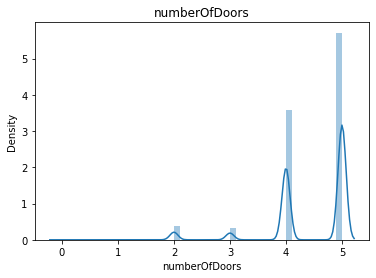

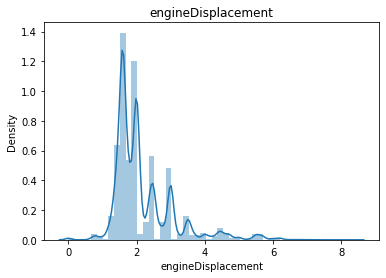

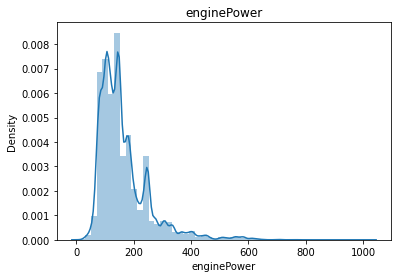

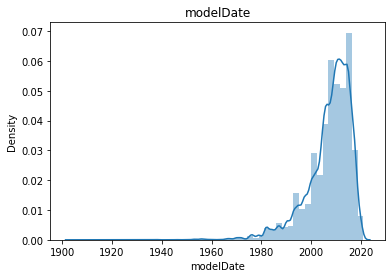

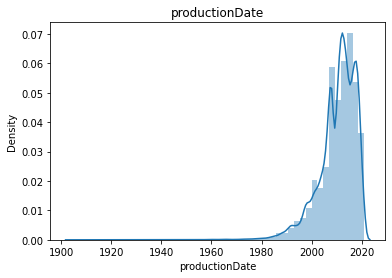

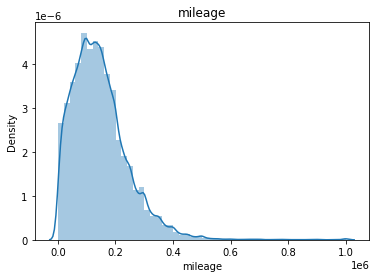

In [196]:
for i in num_cols:
    plt.figure()
    sns.distplot(cars[i])
    plt.title(i)

Видим, что распределения у признаков близки к нормальным, справа или слева имеются длинные хвосты.

Посмотрим матрицу корреляций числовых признаков

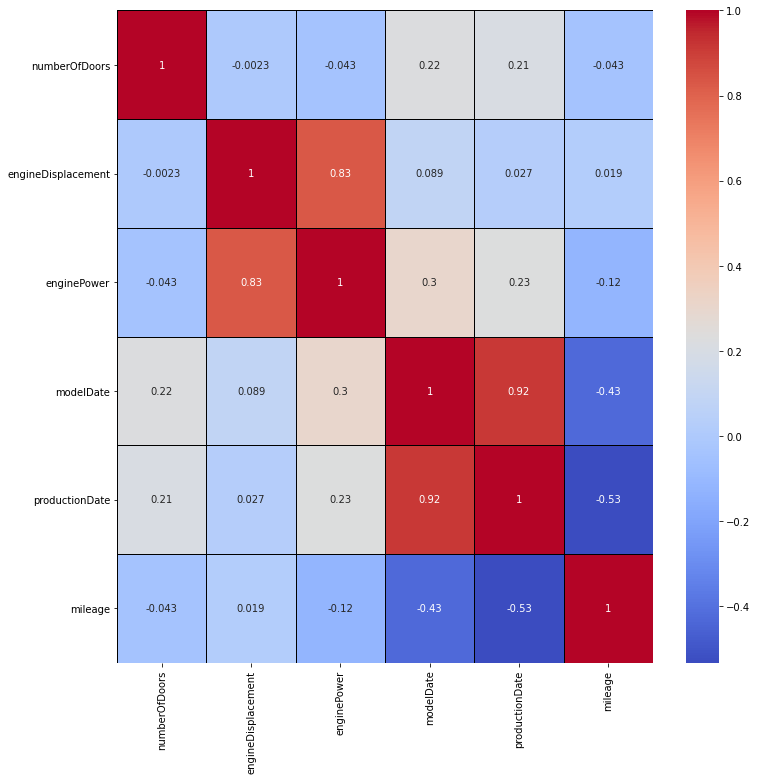

In [197]:
sns.heatmap(cars[num_cols].corr(),annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(12,12)

При рассмотрении матрицы корреляций, можно сделать следующие выводы:
- наблюдается высокая корреляция (0.92) между 'modelDate' и 'productionDate', видимо, имеет смысл один из этих признаков убрать или заменить
- корреляция 0.84 между 'enginePower' и 'engineDisplacement'

# Категориальные признаки

In [198]:
for col in cat_cols:
    print(col, cars[col].nunique(), '\n', cars[col].value_counts()[:3], '\n')

brand 51 
 VAZ           11003
VOLKSWAGEN     9195
MERCEDES       8643
Name: brand, dtype: int64 

vendor 6 
 EUROPEAN    57108
JAPANESE    28522
RUSSIAN     16307
Name: vendor, dtype: int64 

bodyType 4 
 1    62120
2    40161
4     6512
Name: bodyType, dtype: int64 

color 11 
 чёрный    27981
белый     21060
серый     14662
Name: color, dtype: int64 

model_name 101 
 other      51196
OCTAVIA     2463
POLO        1707
Name: model_name, dtype: int64 

fuelType 5 
 бензин    95708
дизель    16335
гибрид      453
Name: fuelType, dtype: int64 

vehicleTransmission 4 
 автоматическая      53177
механическая        41147
роботизированная     9903
Name: vehicleTransmission, dtype: int64 

ПТС 2 
 Оригинал    98139
Дубликат    14646
Name: ПТС, dtype: int64 

Владельцы 3 
 3 или более    47467
1 владелец     37257
2 владельца    28061
Name: Владельцы, dtype: int64 

Привод 3 
 передний    59068
полный      42588
задний      11129
Name: Привод, dtype: int64 



# Часть 3.  Feature Engineering

Из признаков 'modelDate' и 'productionDate' создадим признак 'model_age' - новизна модели на момент производства.

In [199]:
cars['model_age'] = cars['productionDate'] - cars['modelDate']
cars['model_age'] = cars['model_age'].apply(lambda x: 0 if x < 0 else x)
num_cols.append('model_age')

Посмотрим на гистограмму признака

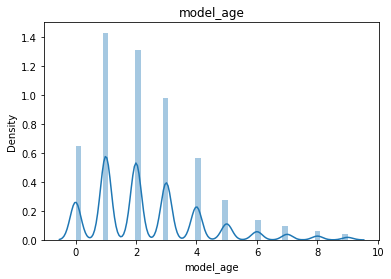

In [200]:
plt.figure()
sns.distplot(cars['model_age'][cars['model_age'] < 10])
plt.title('model_age')
plt.show()

In [201]:
# создадим признак возраст автомобиля
cars['age'] = 2021 - cars['productionDate']
num_cols.append('age')

Снова построим матрицу корреляций по числовым признакам

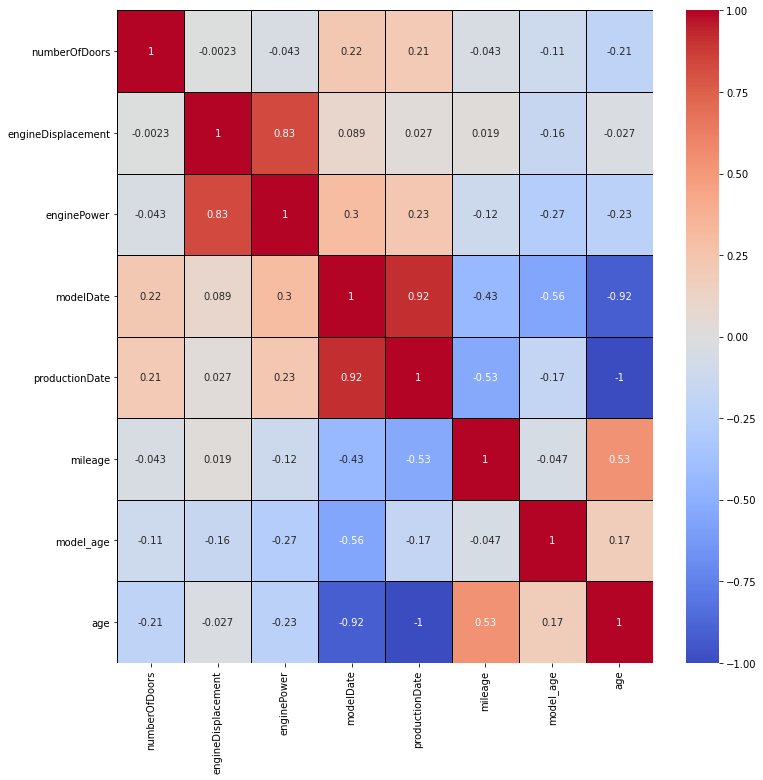

In [202]:
sns.heatmap(cars[num_cols].corr(),annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(12,12)

Посмотрим значимость числовых признаков для целевой переменной:

<AxesSubplot:>

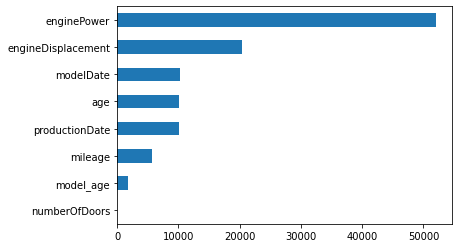

In [203]:
# Значимость числовых признаков для целевой по f_regression (линейная зависимость):
imp_num = Series(f_regression(cars[cars['sample'] == 1][num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Создадим полиномиальные новые признаки на основе двух числовых 'productionDate' и 'enginePower' и нормируем их

In [204]:
pf = PolynomialFeatures(3)
poly_features = pf.fit_transform(cars[[ 'productionDate', 'enginePower']])
poly = pd.DataFrame(poly_features).drop([0,1,2,3,4,6,8], axis = 1)
poly.columns = ['power_date5', 'power_date7', 'power_date9']

for col in list(poly.columns):
    col_max = poly[col].max()    
    poly[col] = poly[col].apply(lambda x: int(round(x/col_max*100000, 0)))
    
cars = pd.concat([cars, poly], axis=1)
num_cols = num_cols + list(poly.columns)

Создадим еще два новых признака

In [205]:
maeg = cars.groupby('model_age')['engineDisplacement'].mean().to_dict()
cars['maeg'] = cars['model_age'].map(maeg)
num_cols.append('maeg')
pep = cars.groupby('productionDate')['enginePower'].mean().to_dict()
cars['pep'] = cars['productionDate'].map(pep)
num_cols.append('pep')

<AxesSubplot:>

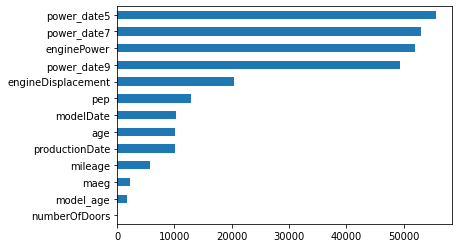

In [206]:
# Проверим значимость полиномиальных признаков
imp_num = Series(f_regression(cars[cars['sample'] == 1][num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [207]:
cars1 = cars.copy()
cars1['price'] = y
num_cols1 = num_cols.copy()
num_cols1.append('price')

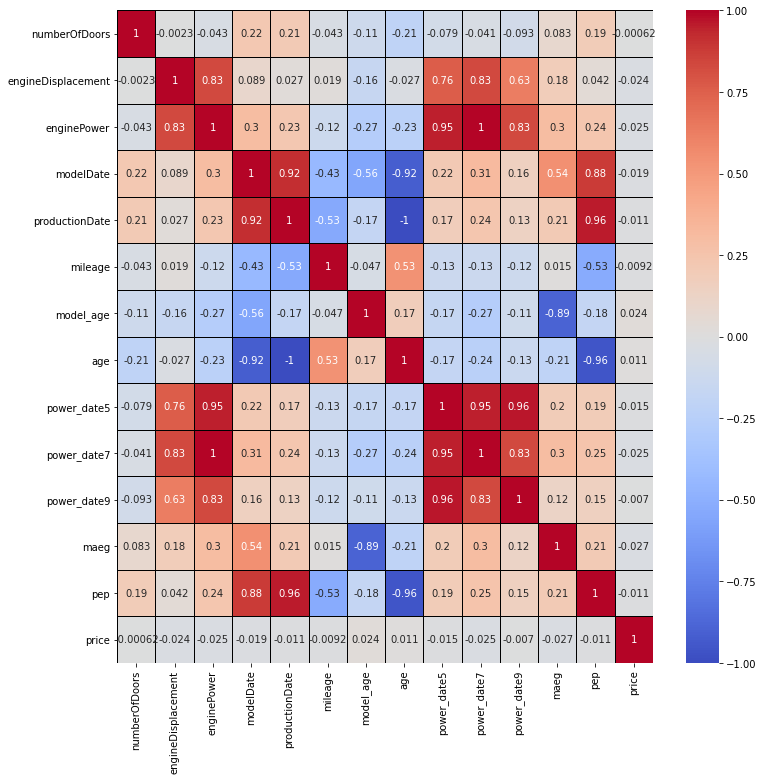

In [208]:
sns.heatmap(cars1[num_cols1].corr(),annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(12,12)

In [209]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112785 entries, 0 to 112784
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             112785 non-null  int64  
 1   brand                112785 non-null  object 
 2   color                112785 non-null  object 
 3   fuelType             112785 non-null  object 
 4   modelDate            112785 non-null  int64  
 5   model_name           112785 non-null  object 
 6   numberOfDoors        112785 non-null  int64  
 7   productionDate       112785 non-null  int64  
 8   vehicleTransmission  112785 non-null  object 
 9   engineDisplacement   112785 non-null  float64
 10  enginePower          112785 non-null  float64
 11  mileage              112785 non-null  int64  
 12  vendor               112785 non-null  object 
 13  ПТС                  112785 non-null  object 
 14  Владельцы            112785 non-null  object 
 15  Привод           

### Итоги  
В результате EDA и Feature Engineering добавлены:  
- 1 новый бинарный категориальный признак  
- 4 новых числовых, 3 из которых - полиномиальные  
- 2 новых числовых, переделанных из категориальных  

 
Датасет содержит 13 числовых и 6 категориальных признаков  
Сохранены сильно скоррелированные признаки для отбора в ходе тестирования моделей  

# Label Encoding

In [210]:
# Кодируем категориальные признаки
for col in cat_cols:
    cars[col] = cars[col].astype('category').cat.codes

Посмотрим на значимость категориальных признаков

<AxesSubplot:>

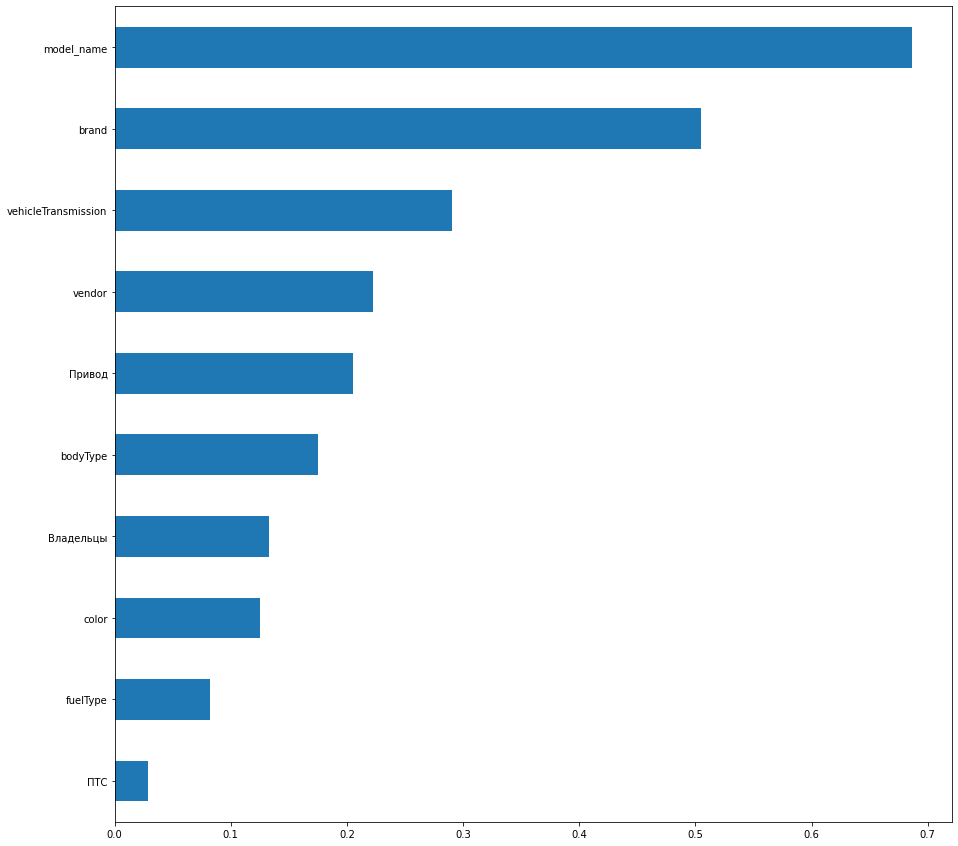

In [211]:
plt.figure(figsize=(15,15))
imp_cat = pd.Series(mutual_info_regression(cars[cars['sample'] == 1][cat_cols], y,
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [212]:
X_train_test = cars.copy()
X_train_test.head(3)

bodyType  brand  color  fuelType  modelDate  model_name  numberOfDoors  \
0         0     21      2         0       2017          80              4   
1         0     47      7         3       2005          69              5   
2         0     47     10         0       2014          71              4   

   productionDate  vehicleTransmission  engineDisplacement  ...  Привод  \
0            2018                    0                 1.6  ...       1   
1            2007                    3                 2.0  ...       1   
2            2019                    3                 1.4  ...       1   

   count_equip  sample  model_age  age  power_date5  power_date7  power_date9  \
0           46       1          1    3         1454        12023          175   
1            0       1          2   14         1884        13536          259   
2           34       1          5    2         1502        12231          184   

       maeg         pep  
0  2.288595  179.238980  
1  2.228801  152.670264  
2  1.988897  183.336768  

[3 rows x 25 columns]

In [213]:
# Разделяем обратно train и test
train = X_train_test.query('sample == 1').drop(['sample'], axis=1)
test = X_train_test.query('sample == 0').drop(['sample'], axis=1)

In [214]:
columns_new = cat_cols + num_cols
columns_new.append('count_equip')
train = train[columns_new]
test = test[columns_new]

In [215]:
train

brand  vendor  bodyType  color  model_name  fuelType  \
0         21       4         0      2          80         0   
1         47       2         0      7          69         3   
2         47       2         0     10          71         0   
3         32       2         1     10         100         0   
4         47       2         0     10          46         0   
...      ...     ...       ...    ...         ...       ...   
78094     25       2         1     10         100         0   
78095     18       2         0     10          86         0   
78096     13       1         0      7         100         0   
78097     42       3         1      9         100         0   
78098     21       4         0      2          80         0   

       vehicleTransmission  ПТС  Владельцы  Привод  ...  productionDate  \
0                        0    1          0       1  ...            2018   
1                        3    1          1       1  ...            2007   
2                        3    1          0       1  ...            2019   
3                        0    1          1       2  ...            2018   
4                        2    1          1       1  ...            2015   
...                    ...  ...        ...     ...  ...             ...   
78094                    3    1          1       1  ...            2018   
78095                    0    1          2       1  ...            2007   
78096                    2    0          2       1  ...            2008   
78097                    1    1          0       2  ...            2020   
78098                    2    1          1       1  ...            2019   

       mileage  model_age  age  power_date5  power_date7  power_date9  \
0       165000          1    3         1454        12023          175   
1       251000          2   14         1884        13536          259   
2        80748          5    2         1502        12231          184   
3        92000          4    3        17443        41641         7285   
4       141000          1    6          694         8284           58   
...        ...        ...  ...          ...          ...          ...   
78094    35000          1    3         2339        15249          358   
78095   206000          6   14         2844        16630          479   
78096   134000          2   13          849         9098           78   
78097    30000          2    1         3290        18119          597   
78098    55000          2    2          961         9785           94   

           maeg         pep  count_equip  
0      2.288595  179.238980           46  
1      2.228801  152.670264            0  
2      1.988897  183.336768           34  
3      2.089591  179.238980           66  
4      2.288595  185.800834           12  
...         ...         ...          ...  
78094  2.288595  179.238980            5  
78095  1.912789  152.670264           47  
78096  2.228801  160.873940           21  
78097  2.228801  194.202527           80  
78098  2.228801  183.336768           34  

[78099 rows x 24 columns]

In [216]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78099 entries, 0 to 78098
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                78099 non-null  int8   
 1   vendor               78099 non-null  int8   
 2   bodyType             78099 non-null  int8   
 3   color                78099 non-null  int8   
 4   model_name           78099 non-null  int8   
 5   fuelType             78099 non-null  int8   
 6   vehicleTransmission  78099 non-null  int8   
 7   ПТС                  78099 non-null  int8   
 8   Владельцы            78099 non-null  int8   
 9   Привод               78099 non-null  int8   
 10  numberOfDoors        78099 non-null  int64  
 11  engineDisplacement   78099 non-null  float64
 12  enginePower          78099 non-null  float64
 13  modelDate            78099 non-null  int64  
 14  productionDate       78099 non-null  int64  
 15  mileage              78099 non-null 

Для модели CatBoost нерекомендуют обрабатывать признаки, создадим копии датасетов для этой модели

In [217]:
train_catboost = train.copy()
test_catboost = test.copy()

Преобразуем признак **model_name** методом Target Encoder

In [218]:
te = ce.TargetEncoder(cols=['model_name'])

In [219]:
train = te.fit_transform(train, y)

In [220]:
test = te.transform(test)

In [221]:
train

brand  vendor  bodyType  color    model_name  fuelType  \
0         21       4         0      2  9.649468e+05         0   
1         47       2         0      7  1.012552e+06         3   
2         47       2         0     10  9.107001e+05         0   
3         32       2         1     10  9.992632e+05         0   
4         47       2         0     10  9.238650e+05         0   
...      ...     ...       ...    ...           ...       ...   
78094     25       2         1     10  9.992632e+05         0   
78095     18       2         0     10  9.774131e+05         0   
78096     13       1         0      7  9.992632e+05         0   
78097     42       3         1      9  9.992632e+05         0   
78098     21       4         0      2  9.649468e+05         0   

       vehicleTransmission  ПТС  Владельцы  Привод  ...  productionDate  \
0                        0    1          0       1  ...            2018   
1                        3    1          1       1  ...            2007   
2                        3    1          0       1  ...            2019   
3                        0    1          1       2  ...            2018   
4                        2    1          1       1  ...            2015   
...                    ...  ...        ...     ...  ...             ...   
78094                    3    1          1       1  ...            2018   
78095                    0    1          2       1  ...            2007   
78096                    2    0          2       1  ...            2008   
78097                    1    1          0       2  ...            2020   
78098                    2    1          1       1  ...            2019   

       mileage  model_age  age  power_date5  power_date7  power_date9  \
0       165000          1    3         1454        12023          175   
1       251000          2   14         1884        13536          259   
2        80748          5    2         1502        12231          184   
3        92000          4    3        17443        41641         7285   
4       141000          1    6          694         8284           58   
...        ...        ...  ...          ...          ...          ...   
78094    35000          1    3         2339        15249          358   
78095   206000          6   14         2844        16630          479   
78096   134000          2   13          849         9098           78   
78097    30000          2    1         3290        18119          597   
78098    55000          2    2          961         9785           94   

           maeg         pep  count_equip  
0      2.288595  179.238980           46  
1      2.228801  152.670264            0  
2      1.988897  183.336768           34  
3      2.089591  179.238980           66  
4      2.288595  185.800834           12  
...         ...         ...          ...  
78094  2.288595  179.238980            5  
78095  1.912789  152.670264           47  
78096  2.228801  160.873940           21  
78097  2.228801  194.202527           80  
78098  2.228801  183.336768           34  

[78099 rows x 24 columns]

In [222]:
test

brand  vendor  bodyType  color    model_name  fuelType  \
78099      39       2         0      9  1.121393e+06         0   
78100      39       2         0     10  1.121393e+06         0   
78101      39       2         0      8  9.992632e+05         0   
78102      39       2         0      5  1.121393e+06         0   
78103      39       2         0      2  1.121393e+06         0   
...       ...     ...       ...    ...           ...       ...   
112780      1       2         0      5  9.992632e+05         0   
112781      1       2         0     10  9.992632e+05         3   
112782      1       2         0      8  9.992632e+05         0   
112783      1       2         1      5  9.992632e+05         3   
112784      1       2         1     10  9.816335e+05         3   

        vehicleTransmission  ПТС  Владельцы  Привод  ...  productionDate  \
78099                     3    1          2       1  ...            2014   
78100                     2    1          0       1  ...            2017   
78101                     3    1          0       1  ...            2014   
78102                     0    1          0       1  ...            2014   
78103                     0    1          0       1  ...            2012   
...                     ...  ...        ...     ...  ...             ...   
112780                    0    1          2       0  ...            2014   
112781                    0    1          0       2  ...            2018   
112782                    0    0          2       0  ...            1997   
112783                    0    1          1       2  ...            2013   
112784                    0    1          2       2  ...            2008   

        mileage  model_age  age  power_date5  power_date7  power_date9  \
78099     74000          1    7         1060        10223          109   
78100     60563          0    4         1163        10742          125   
78101     88000          1    7         2221        14799          331   
78102     95000          1    7         1163        10710          125   
78103     58536          4    9         2221        14770          331   
...         ...        ...  ...          ...          ...          ...   
112780   115000          3    7         1778        13241          237   
112781    98000          2    3         3470        18572          646   
112782   360000          2   24         2778        16273          463   
112783    90500          1    8         3254        17897          587   
112784   240000          2   13         5308        22744         1223   

            maeg         pep  count_equip  
78099   2.288595  173.857082           36  
78100   2.280677  174.521017           34  
78101   2.288595  173.857082           55  
78102   2.288595  173.857082           52  
78103   2.089591  167.808353           29  
...          ...         ...          ...  
112780  2.165157  173.857082           42  
112781  2.228801  179.238980            0  
112782  2.228801  124.728333            0  
112783  2.288595  171.524457           45  
112784  2.228801  160.873940           10  

[34686 rows x 24 columns]

In [223]:
cat_cols1 = cat_cols.copy()

In [224]:
cat_cols1.remove('model_name')

Преобразуем категориальные признаки

In [225]:
ohe = OneHotEncoder(sparse = False)

In [226]:
X_cat_train = ohe.fit_transform(train[cat_cols1].values)
X_cat_test = ohe.transform(test[cat_cols1].values)

In [227]:
scaler = StandardScaler()

In [228]:
num_cols

['numberOfDoors',
 'engineDisplacement',
 'enginePower',
 'modelDate',
 'productionDate',
 'mileage',
 'model_age',
 'age',
 'power_date5',
 'power_date7',
 'power_date9',
 'maeg',
 'pep']

Избавимся от мультиколинеарности в числовых признаках

In [229]:
pca1 = PCA(n_components = 1)
pca2 = PCA(n_components = 2)
pca3 = PCA(n_components = 1)
X_num_pca2 = pca2.fit_transform(train[['engineDisplacement', 'enginePower','power_date5', 'power_date7', 'power_date9',]].values)
X_num_pca1 = pca1.fit_transform(train[['modelDate', 'productionDate', 'pep']].values)
X_num_pca3 = pca3.fit_transform(train[['model_age', 'maeg']].values)
X_test1 = pca1.transform(test[['modelDate', 'productionDate', 'pep']].values)
X_test2 = pca2.transform(test[['engineDisplacement', 'enginePower','power_date5', 'power_date7', 'power_date9',]].values)
X_test3 = pca3.transform(test[['model_age', 'maeg']].values)

In [230]:
X_num_pca = np.hstack([train[['numberOfDoors', 'enginePower', 'modelDate', 'mileage']].values, 
                      X_num_pca2, X_num_pca1, X_num_pca3])
X_num_test = np.hstack([test[['numberOfDoors', 'enginePower', 'modelDate', 'mileage']].values,
                       X_test2, X_test1, X_test3])
                       

Стандартизируем числовые данные

In [231]:
X_num_train = scaler.fit_transform(X_num_pca)
X_num_test1 = scaler.transform(X_num_test)

In [232]:
X_num_train1 = X_num_train.copy()

<AxesSubplot:>

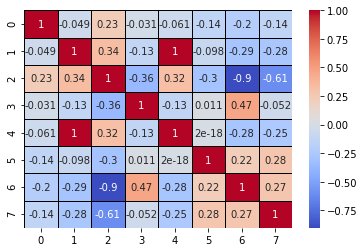

In [233]:
sns.heatmap(np.corrcoef(X_num_train1.T), annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')

<AxesSubplot:>

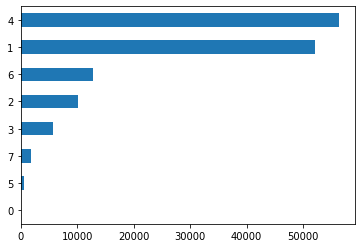

In [234]:
imp_num = Series(f_regression(X_num_train1, y)[0])
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [235]:
X = np.hstack([X_num_train, X_cat_train, np.array(train.model_name).reshape(-1,1), np.array(train.count_equip).reshape(-1,1)])
Xtest = np.hstack([X_num_test1, X_cat_test, np.array(test.model_name).reshape(-1,1), np.array(test.count_equip).reshape(-1,1)])


Приведем наш таргет из train к значеним по тесту. Как видно из графика цены за период выросли в среднем на 30%.

In [236]:
Image("auto-price.png")

FileNotFoundError: No such file or directory: 'auto-price.png'

FileNotFoundError: No such file or directory: 'auto-price.png'

<IPython.core.display.Image object>

In [237]:
# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Часть 4. Модели

## Наивная модель

Эта модель будет предсказывать среднюю цену. C ней будем сравнивать другие модели.

In [238]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)
y_pred_dr = dr.predict(X_test)
mape_dr = mape(y_test, y_pred_dr)
print(mape_dr)

321.6496572076584


## XGB

Подбор гиперпараметров

In [239]:
def objective(trial, data=X, target=y):
    
    # Делим train для обучения и проверки моделей
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    
    params = {
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_loguniform('gamma', 4, 7),
#         'subsample': trial.suggest_loguniform('subsample', 0.1, 1),
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        
        'n_estimators' : trial.suggest_int('n_estimators', 1500, 2000),
        
               
        }

    model = XGBRegressor(**params, random_state = 42, min_child_weight=1,subsample=1, gamma=6, n_jobs=-1)      
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Смотрим финальную метрику
    mape_ = mape(y_test, y_pred)
    
    return mape_

In [240]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='minimize', sampler=RandomSampler())  # Минимизируем ошибку
study.optimize(objective, n_trials=5)              

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2021-09-05 20:44:35,826] A new study created in memory with name: no-name-1b3b0c8b-4560-4e00-a1ce-2e4a85995219
[I 2021-09-05 20:52:19,855] Trial 0 finished with value: 17.218376745428184 and parameters: {'max_depth': 13, 'n_estimators': 1729}. Best is trial 0 with value: 17.218376745428184.
[I 2021-09-05 20:59:33,926] Trial 1 finished with value: 17.188724701746548 and parameters: {'max_depth': 12, 'n_estimators': 1764}. Best is trial 1 with value: 17.188724701746548.
[I 2021-09-05 21:07:17,529] Trial 2 finished with value: 17.188735950085587 and parameters: {'max_depth': 12, 'n_estimators': 1877}. Best is trial 1 with value: 17.188724701746548.
[I 2021-09-05 21:15:36,280] Trial 3 finished with value: 17.12524991103459 and parameters: {'max_depth': 14, 'n_estimators': 1753}. Best is trial 3 with value: 17.12524991103459.
[I 2021-09-05 21:21:47,232] Trial 4 finished with value: 17.38679676478904 and parameters: {'max_depth': 10, 'n_estimators': 1854}. Best is trial 3 with value: 17.1

Number of finished trials: 5
Best trial: {'max_depth': 14, 'n_estimators': 1753}
Best score: 17.12524991103459


Number of finished trials: 5

Best trial: {'max_depth': 14, 'n_estimators': 1970}

Best score: 17.12524991103459

Number of finished trials: 5

Best trial: {'max_depth': 15, 'n_estimators': 1599}

Best score: 0.1735860225867057

In [241]:
# История оптимизации
plot_optimization_history(study)
# Значимость гиперпараметров при настройке
plot_param_importances(study)
# Выводим лучшие гиперпараметры
study.best_params

{'max_depth': 14, 'n_estimators': 1753}

In [242]:
params_xgb = study.best_params
xgb_best = XGBRegressor(**params_xgb, random_state = 42, min_child_weight=1,subsample=1, gamma=6, n_jobs=-1)
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)
mape_xgb = mape(y_test, y_pred)
print(mape_xgb)

17.12524991103459


17.12524991103459

**Точность XGB по метрике MAPE 17,36%**

In [243]:
# сабмит результата
y_pred_test_xgb = xgb_best.predict(Xtest)
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test_xgb})
submit.to_csv('./submission_xgb.csv', index=False)

Модель на дефолтных настройках

In [244]:
xgb_def = XGBRegressor(random_state = 42, n_jobs=-1)
xgb_def.fit(X_train, y_train)
y_pred = xgb_def.predict(X_test)
mape_xgb_def = mape(y_test, y_pred)
print(mape_xgb_def)

22.349463148531843


0.22329625806022135

In [245]:
# сабмит результата
y_pred_test_xgb_def = xgb_def.predict(Xtest)
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test_xgb_def})
submit.to_csv('g:\\SkillFactory\Выбираем авто выгодно\\submission_xgb_def.csv', index=False)

## Lasso

In [246]:
def objective(trial, data=X, target=y):
    
    # Делим train для обучения и проверки моделей
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    
    params = {'alpha' : trial.suggest_loguniform('alpha', 0.1, 0.9),
              'max_iter' : trial.suggest_int('max_iter', 1500, 2000)}
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = Lasso(**params, random_state=42)      
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Смотрим финальную метрику
    mape_ = mape(y_test, y_pred)
    
    return mape_

In [247]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='minimize', sampler=RandomSampler())  # Минимизируем ошибку
study.optimize(objective, n_trials=10)              # Количество итераций 

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2021-09-05 21:30:41,283] A new study created in memory with name: no-name-4a3b641b-e167-45f1-a245-10e4eae16359
[I 2021-09-05 21:30:59,753] Trial 0 finished with value: 119.09646616180669 and parameters: {'alpha': 0.4797146805554755, 'max_iter': 1843}. Best is trial 0 with value: 119.09646616180669.
[I 2021-09-05 21:31:17,800] Trial 1 finished with value: 119.12968560675935 and parameters: {'alpha': 0.2566938471299106, 'max_iter': 1799}. Best is trial 0 with value: 119.09646616180669.
[I 2021-09-05 21:31:37,497] Trial 2 finished with value: 119.03584075127824 and parameters: {'alpha': 0.686911290029889, 'max_iter': 1925}. Best is trial 2 with value: 119.03584075127824.
[I 2021-09-05 21:31:55,535] Trial 3 finished with value: 119.14690906773798 and parameters: {'alpha': 0.43923659667607284, 'max_iter': 1774}. Best is trial 2 with value: 119.03584075127824.
[I 2021-09-05 21:32:15,719] Trial 4 finished with value: 118.99253658181338 and parameters: {'alpha': 0.16026564211897115, 'max_it

Number of finished trials: 10
Best trial: {'alpha': 0.16026564211897115, 'max_iter': 1989}
Best score: 118.99253658181338


Number of finished trials: 10

Best trial: {'alpha': 0.10117653332575481, 'max_iter': 1962}

Best score: 1.151587848677538

**Точность Lasso по метрике MAPE 115,16%**

Можно сделать вывод, что данная модель не подходит для решения данной задачи.

In [248]:
# История оптимизации
plot_optimization_history(study)
# Значимость гиперпараметров при настройке
plot_param_importances(study)
# Выводим лучшие гиперпараметры
study.best_params

{'alpha': 0.16026564211897115, 'max_iter': 1989}

In [249]:
params_lasso = study.best_params
lasso_best = Lasso(**params_lasso, random_state=42)
lasso_best.fit(X_train, y_train)
y_pred = lasso_best.predict(X_test)
mape_lasso = mape(y_test, y_pred)
print(mape_lasso)

118.99253658181338


1.151587848677538

In [250]:
lasso_def = Lasso(random_state=42)
lasso_def.fit(X_train, y_train)
y_pred = lasso_def.predict(X_test)
mape_lasso = mape(y_test, y_pred)
print(mape_lasso)

119.72040170504611


1.1569961608873984

## Ridge

In [251]:
def objective(trial, data=X, target=y):
    
    # Делим train для обучения и проверки моделей
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    
    params = {'alpha' : trial.suggest_loguniform('alpha', 0.1, 0.9),
              'max_iter' : trial.suggest_int('max_iter', 1500, 2000)}
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = Ridge(**params, random_state=42)      
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Смотрим финальную метрику
    mape_ = mape(y_test, y_pred)
    
    return mape_

In [252]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='minimize', sampler=RandomSampler())  # Минимизируем ошибку
study.optimize(objective, n_trials=50)              # Количество итераций = 5

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2021-09-05 21:34:17,993] A new study created in memory with name: no-name-f087c7ea-49a0-48f9-8d63-960714496136
[I 2021-09-05 21:34:18,142] Trial 0 finished with value: 108.81583501606922 and parameters: {'alpha': 0.25068014224904017, 'max_iter': 1564}. Best is trial 0 with value: 108.81583501606922.
[I 2021-09-05 21:34:18,295] Trial 1 finished with value: 108.82112331111404 and parameters: {'alpha': 0.251861105078098, 'max_iter': 1704}. Best is trial 0 with value: 108.81583501606922.
[I 2021-09-05 21:34:18,446] Trial 2 finished with value: 108.12601012100808 and parameters: {'alpha': 0.10049502870928703, 'max_iter': 1967}. Best is trial 2 with value: 108.12601012100808.
[I 2021-09-05 21:34:18,600] Trial 3 finished with value: 109.60474846717553 and parameters: {'alpha': 0.4370743931341553, 'max_iter': 1709}. Best is trial 2 with value: 108.12601012100808.
[I 2021-09-05 21:34:18,754] Trial 4 finished with value: 108.55127566865546 and parameters: {'alpha': 0.19226828722625997, 'max_i

Number of finished trials: 50
Best trial: {'alpha': 0.10049502870928703, 'max_iter': 1967}
Best score: 108.12601012100808


Number of finished trials: 50

Best trial: {'alpha': 0.10891875487021802, 'max_iter': 1948}

Best score: 1.0605204744102907

In [253]:
# История оптимизации
plot_optimization_history(study)
# Значимость гиперпараметров при настройке
plot_param_importances(study)
# Выводим лучшие гиперпараметры
study.best_params
params_ridge = study.best_params
ridge_best = Ridge(**params_ridge, random_state=42)
ridge_best.fit(X_train, y_train)
y_pred = ridge_best.predict(X_test)
mape_ridge = mape(y_test, y_pred)
print(mape_ridge)

108.12601012100808


1.0605204744102907

In [254]:
ridge = Ridge(random_state=42)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
mape_ridge = mape(y_test, y_pred)
print(mape_ridge)

111.5751043660655


1.0906720909968588

**Точность Ridge по метрике MAPE 109,07%**

## Линейная регрессия

In [255]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mape_lr = mape(y_test, y_pred)
print(mape_lr)

107.64146039450245


1.0553228227878577

**Точность LinearRegression по метрике MAPE 105,53%**

Модель не подходит, возможно стоило попробовать только на численных данных.

## Random Forest

In [256]:
def objective(trial, data=X, target=y):
    
    # Делим train для обучения и проверки моделей
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    

    
    params = {'n_estimators' : trial.suggest_int('n_estimators', 1500, 2000), 
              'max_depth' : trial.suggest_int('max_depth', 15, 20)}
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)      
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Смотрим финальную метрику
    mape_ = mape(y_test, y_pred)
    
    return mape_

In [257]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='minimize', sampler=RandomSampler())  # Минимизируем ошибку
study.optimize(objective, n_trials=5)              # Количество итераций = 5

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2021-09-05 21:34:43,268] A new study created in memory with name: no-name-7cd54ee7-1993-48f2-94e4-79570d6580bb
[I 2021-09-05 21:41:58,329] Trial 0 finished with value: 19.95048041671585 and parameters: {'n_estimators': 1591, 'max_depth': 15}. Best is trial 0 with value: 19.95048041671585.
[I 2021-09-05 21:47:55,716] Trial 1 finished with value: 19.956025313176365 and parameters: {'n_estimators': 1532, 'max_depth': 15}. Best is trial 0 with value: 19.95048041671585.
[I 2021-09-05 21:54:55,018] Trial 2 finished with value: 18.32157186754357 and parameters: {'n_estimators': 1604, 'max_depth': 18}. Best is trial 2 with value: 18.32157186754357.
[I 2021-09-05 22:02:19,969] Trial 3 finished with value: 19.24664146567636 and parameters: {'n_estimators': 1834, 'max_depth': 16}. Best is trial 2 with value: 18.32157186754357.
[I 2021-09-05 22:08:48,784] Trial 4 finished with value: 19.950986587317164 and parameters: {'n_estimators': 1637, 'max_depth': 15}. Best is trial 2 with value: 18.32157

Number of finished trials: 5
Best trial: {'n_estimators': 1604, 'max_depth': 18}
Best score: 18.32157186754357


Number of finished trials: 5

Best trial: {'n_estimators': 1737, 'max_depth': 20}

Best score: 0.17819674574516994

In [258]:
# История оптимизации
plot_optimization_history(study)
# Значимость гиперпараметров при настройке
plot_param_importances(study)
# Выводим лучшие гиперпараметры
study.best_params

{'n_estimators': 1604, 'max_depth': 18}

In [259]:
params_rfr = study.best_params
rfr_best = RandomForestRegressor(**params_rfr, random_state=42, n_jobs=-1)
rfr_best.fit(X_train, y_train)
y_pred = rfr_best.predict(X_test)
mape_rfr = mape(y_test, y_pred)
print(mape_rfr)

18.32157186754357


0.17819674574516994

In [260]:
# сабмит результата
y_pred_test_rfr = rfr_best.predict(Xtest)
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test_rfr})
submit.to_csv('../input/sf-dst-car-price-prediction/submission_rfr.csv', index=False)

OSError: [Errno 30] Read-only file system: '../input/sf-dst-car-price-prediction/submission_rfr.csv'

In [ ]:
# постообработка данных, приведение цены к целому количеству тысяч, т.к. никто не пришет 1532874р, а 1532000р
y_pred_test_rfr_post = np.round(y_pred_test_rfr/1000)*1000

In [ ]:
# сабмит результата
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test_rfr_post})
submit.to_csv('g:\\SkillFactory\Выбираем авто выгодно\\submission_rfr_post.csv', index=False)

In [ ]:
rfr_def = RandomForestRegressor(random_state=42, n_jobs=-1)
rfr_def.fit(X_train, y_train)
y_pred = rfr_def.predict(X_test)
mape_rfr_def = mape(y_test, y_pred)
print(mape_rfr_def)

0.17574848704208063

**Точность Random Forest по метрике MAPE 17,57%**

In [ ]:
# сабмит результата
y_pred_test_rfr_def = rfr_def.predict(Xtest)
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test_rfr_def})
submit.to_csv('./submission_rfr_def.csv', index=False)

## ADA

In [ ]:
def objective(trial, data=X, target=y):
    
    # Делим train для обучения и проверки моделей
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    

    
    params = {'n_estimators' : trial.suggest_int('n_estimators', 1500, 2000)}
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = AdaBoostRegressor(**params, random_state=42)      
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Смотрим финальную метрику
    mape_ = mape(y_test, y_pred)
    
    return mape_

In [ ]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='minimize', sampler=RandomSampler())  # Минимизируем ошибку
study.optimize(objective, n_trials=5)              # Количество итераций = 5

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

Number of finished trials: 5

Best trial: {'n_estimators': 1919}

Best score: 6.236800200459699

In [ ]:
# История оптимизации
plot_optimization_history(study)
# Выводим лучшие гиперпараметры
study.best_params

In [ ]:
params_ada = study.best_params
ada_best = AdaBoostRegressor(**params_ada, random_state=42)
ada_best.fit(X_train, y_train)
y_pred = ada_best.predict(X_test)
mape_ada = mape(y_test, y_pred)
print(mape_ada)

6.236800200459699

**Точность ADABoost по метрике MAPE 623,68%**

## PassiveAggressiveRegressor

In [ ]:
def objective(trial, data=X, target=y):
    
    # Делим train для обучения и проверки моделей
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    
    params = {'C' : trial.suggest_loguniform('C', 0.01, 10),
              'max_iter' : trial.suggest_int('max_iter', 1000, 3000)}
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = PassiveAggressiveRegressor(**params, random_state=42, early_stopping=True)      
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Смотрим финальную метрику
    mape_ = mape(y_test, y_pred)
    
    return mape_

In [ ]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='minimize', sampler=RandomSampler())  # Минимизируем ошибку
study.optimize(objective, n_trials=100)              # Количество итераций 

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

Number of finished trials: 100

Best trial: {'C': 0.16996104590673936, 'max_iter': 2620}

Best score: 0.5988018975587224

In [ ]:
# История оптимизации
plot_optimization_history(study)
# Значимость гиперпараметров при настройке
plot_param_importances(study)
# Выводим лучшие гиперпараметры
study.best_params
params_par = study.best_params
par_best = PassiveAggressiveRegressor(**params_par, random_state=42, early_stopping=True)
par_best.fit(X_train, y_train)
y_pred = par_best.predict(X_test)
mape_par = mean_absolute_percentage_error(y_test, y_pred)
print(mape_par)

0.5988018975587224

**Точность PassiveAggressiveRegressor по метрике MAPE 59,88%**

# Stacking

In [ ]:
# cv = KFold(n_splits=10, shuffle=True)

In [ ]:
estimators = [('xgb', xgb_best),
              ('rfr', rfr_def)]
stacked = StackingRegressor(estimators=estimators, 
                            final_estimator=LinearRegression(normalize=True, n_jobs=-1))
stacked.fit(X_train, y_train)
y_pred = stacked.predict(X_test)
mape_ = mape(y_test, y_pred)
print(mape_)

26.24869962137667

0.25378357510952343

**Точность Stacking по метрике MAPE 25,38%**

Несмотря на то, что использовались лучшие модели, результат оказался хуже, чем на моделях по отдельности. 

# Submit

In [ ]:
y_pred_test = stacked.predict(Xtest)

In [ ]:
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test})
submit.to_csv('./submission_stack.csv', index=False)

In [ ]:
y_pred_test_post = np.round(y_pred_test/1000)*1000

In [ ]:
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test_post})
submit.to_csv('g:\\SkillFactory\Выбираем авто выгодно\\submission_stack_post.csv', index=False)

заменим метамодель на экстремальный бустинг

In [ ]:
stacked1 = StackingRegressor(estimators=estimators, passthrough=True,
                            final_estimator=XGBRegressor(random_state = 42, n_jobs=-1))
stacked1.fit(X_train, y_train)
y_pred = stacked1.predict(X_test)
mape1 = mape(y_test, y_pred)
print(mape1)

18.004128561136667

0.1780400545587421

In [ ]:
y_pred_test1 = stacked1.predict(Xtest)
submit1 = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test1})
submit1.to_csv('./submission_stack1.csv', index=False)

# CatBoost

In [ ]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(train_catboost, y, test_size=0.2, shuffle=True, 
                                                                    random_state=42)

In [ ]:
def objective(trial, data=train_catboost, target=y):
    
    # Делим train для обучения и проверки моделей
    X_train, X_test, y_train, y_test = train_test_split(train_catboost, y, test_size=0.2, shuffle=True, random_state=42)
    
    train_pool =Pool(X_train,
                    y_train,
                    cat_features = [x for x in range(len(cat_cols))])
    test_pool = Pool(X_test,
                     cat_features = [x for x in range(len(cat_cols))])
    
       
    params = {'depth' : trial.suggest_int('depth', 13, 15),
              'iterations' : trial.suggest_int('iterations', 1700, 1800)}
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = CatBoostRegressor(**params, metric_period=50, l2_leaf_reg=3, random_seed=42)      
    model.fit(train_pool)
    y_pred = model.predict(test_pool)
    
    #Смотрим финальную метрику
    mape_ = mape(y_test, y_pred)
    
    return mape_

In [ ]:
# Создаем задание для фреймворка
study = optuna.create_study(direction='minimize', sampler=RandomSampler())  # Минимизируем ошибку
study.optimize(objective, n_trials=5)              # Количество итераций 

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

Number of finished trials: 5

Best trial: {'depth': 14, 'iterations': 1722}

Best score: 17.613312987480928

Number of finished trials: 5

Best trial: {'depth': 15, 'iterations': 1792}

Best score: 17.495285332228267

Number of finished trials: 5

Best trial: {'depth': 15, 'iterations': 1794}

Best score: 0.1813147496760255

In [ ]:
# История оптимизации
plot_optimization_history(study)
# Значимость гиперпараметров при настройке
plot_param_importances(study)
# Выводим лучшие гиперпараметры
study.best_params
params_cat = study.best_params
train_pool =Pool(X_train_cat, y_train_cat, cat_features = [x for x in range(len(cat_cols))])
test_pool = Pool(X_test_cat,cat_features = [x for x in range(len(cat_cols))])
cat_best = CatBoostRegressor(**params_cat, metric_period=50, l2_leaf_reg=3, random_seed=42)
cat_best.fit(train_pool)
y_pred_cat = cat_best.predict(test_pool)
mape_cat = mape(y_test_cat, y_pred_cat)
print(mape_cat)

17.495285332228267

0.1813147496760255

In [ ]:
# сабмит результата
y_pred_test_cat = cat_best.predict(test_catboost)
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test_cat})
submit.to_csv('./submission_cat.csv', index=False)

In [ ]:
y_pred_test_cat_post = np.round(y_pred_test_cat/1000)*1000
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_test_cat_post})
submit.to_csv('g:\\SkillFactory\Выбираем авто выгодно\\submission_cat_post.csv', index=False)

In [ ]:
cat_def = CatBoostRegressor(metric_period=50, random_seed=42)
cat_def.fit(X_train_cat, y_train_cat)
y_pred_cat_def = cat_def.predict(X_test_cat)
mape_cat_def = mape(y_test_cat, y_pred_cat_def)
print(mape_cat_def)

0.22053366641380173

In [ ]:
y_pred_cat_def = cat_def.predict(test_catboost)
submit = pd.DataFrame(data={'sell_id':sell_id, 'price':y_pred_cat_def})
submit.to_csv('./submission_cat_def.csv', index=False)

В итоге получили MAPE 19.28% на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или моделям не хватает данных и признаков.

**What's next?**

Или что еще можно сделать, чтоб улучшить результат:

- Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
- Сгенерировать новые признаки
- Попробовать другие комбинации алгоритмов и библиотеки ML